# Libraries

In [205]:
import os, re, glob
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
import random
from collections import Counter
from pathlib import Path
try:
    from torch.amp import autocast, GradScaler
except Exception:
    from torch.cuda.amp import autocast, GradScaler
from collections import defaultdict
import pandas as pd
from torch.optim import lr_scheduler
import json
from sklearn.metrics import ConfusionMatrixDisplay
from torch.optim import lr_scheduler 
import cv2

# Configuration and Helpers

In [188]:
try:
    import psutil
except Exception:
    psutil = None

SEED = 2025
import numpy as np, torch, random, time, os
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

EXPORT_ROOT = r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\LSTM-GRU"
RUN_STAMP   = time.strftime("%Y%m%d-%H%M%S")
EXPORT_DIR  = os.path.join(EXPORT_ROOT, "HybridLSTMGRU", RUN_STAMP)

CONFIG = {
    "DATA_DIRS": [
        r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\KEYPOINTS"
    ],
    "CLASSES": ["Good Morning", "Good Afternoon", "Good Evening", "Hello", "Don't Understand"],
    # data
    "SEQUENCE_LENGTH": 48,
    "BATCH_SIZE": 16,
    "EPOCHS": 80,
    # training
    "LR": 5e-4,
    "WEIGHT_DECAY": 1e-4,
    "DROPOUT": 0.20,
    "PATIENCE": 20,
    # splits
    "VAL_SPLIT": 0.15,
    "TEST_SPLIT": 0.15,
    # model
    "NORM_MODE": "none",  # "none", "seq", "frame"
    "AUG_ON": False, 
    "EXPORT_DIR": EXPORT_DIR,

}

BEST_DIR = r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\LSTM-GRU\best_model"
from pathlib import Path
Path(BEST_DIR).mkdir(parents=True, exist_ok=True)
CONFIG["BEST_DIR"] = BEST_DIR

Using device: cuda


In [189]:
# ---- Helpers ----
def _next_run_id(dir_path, prefix="run"):
    """
    Scan dir for files or subfolders named like 'run<number>.*' or 'run<number>'.
    Returns the next integer id (starting at 1).
    """
    p = Path(dir_path)
    p.mkdir(parents=True, exist_ok=True)
    pat = re.compile(rf"^{re.escape(prefix)}(\d+)")
    seen = []
    for item in p.iterdir():
        m = pat.match(item.stem)  # use stem so 'run3.pt' -> 'run3'
        if m:
            try:
                seen.append(int(m.group(1)))
            except ValueError:
                pass
    return (max(seen) + 1) if seen else 1

def _latest_run_id(dir_path, prefix="run"):
    p = Path(dir_path)
    if not p.exists():
        return None
    pat = re.compile(rf"^{re.escape(prefix)}(\d+)")
    seen = []
    for item in p.iterdir():
        m = pat.match(item.stem)
        if m:
            try:
                seen.append(int(m.group(1)))
            except ValueError:
                pass
    return max(seen) if seen else None

# Ensure directory exists
Path(CONFIG["BEST_DIR"]).mkdir(parents=True, exist_ok=True)

# ---- Run info ----
RUN_PREFIX = "run"

def _find_latest_run_id(dir_path, prefix=RUN_PREFIX):
    latest = _latest_run_id(dir_path, prefix)
    return latest if latest is not None else 0  # 0 means none yet

CURRENT_RUN_ID = _find_latest_run_id(CONFIG["BEST_DIR"], prefix=RUN_PREFIX)

SKIP_VIDEO_TESTS = False

# ---- Utility helpers ----
class Chrono:
    def __enter__(self): 
        self.t0 = time.time(); 
        return self
    def __exit__(self, *exc): 
        self.dt = time.time() - self.t0

def human_time(sec):
    m, s = divmod(int(sec), 60); h, m = divmod(m, 60)
    return f"{h:d}h {m:02d}m {s:02d}s" if h else (f"{m:d}m {s:02d}s" if m else f"{s:d}s")

def report_memory(prefix=""):
    gpu_mem = None
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        gpu_mem = torch.cuda.memory_allocated() / (1024**2)
    ram = psutil.Process().memory_info().rss / (1024**2) if psutil else None
    msg = []
    if ram is not None: msg.append(f"RAM: {ram:.1f} MB")
    if gpu_mem is not None: msg.append(f"GPU: {gpu_mem:.1f} MB")
    print((prefix+" ").strip(), " | ".join(msg))

report_memory("Init mem")
print(f"Exports will be saved to: {CONFIG['EXPORT_DIR']}")

Init mem RAM: 337.2 MB | GPU: 31.8 MB
Exports will be saved to: C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\LSTM-GRU\HybridLSTMGRU\20251010-030120


# Dataset

In [190]:
# Utilities
def infer_label_from_path(path, classes):
    p = Path(path)
    for c in classes:
        if c in p.parts:
            return classes.index(c)
    stem = p.stem
    for c in classes:
        if stem.startswith(c):
            return classes.index(c)
    raise ValueError(f"Cannot infer label for {path}")

def list_npy_files(data_dirs):
    files = []
    for d in data_dirs:
        if not os.path.isdir(d): continue
        files.extend(glob.glob(str(Path(d) / "**" / "*.npy"), recursive=True))
    return sorted(files)

def effective_length(arr):
    T, D = arr.shape
    if D >= 128:
        flags = arr[:, 126:128]
        valid = (flags.sum(axis=1) > 0.0)
        if valid.any(): return int(valid.sum())
    coords = arr[:, :min(126, D)].reshape(T, -1)
    if T <= 1:
        return 1 if np.abs(coords).sum() > 1e-6 else 0
    diffs = np.abs(np.diff(coords, axis=0)).reshape(T-1, -1)
    mag = diffs.mean(axis=1)
    eps = 1e-6
    active = np.zeros(T, dtype=bool)
    active[0] = (mag[0] > eps) if len(mag) else (np.abs(coords[0]).sum() > eps)
    active[1:] = mag > eps
    if active.any(): return int(active.sum())
    nonzero = (np.abs(coords).sum(axis=1) > 1e-6)
    return int(nonzero.sum()) if nonzero.any() else (T if coords.any() else 0)

def _presence_score(arr):
    T, D = arr.shape
    if D >= 128:
        flags = arr[:, 126:128]
        return ((flags[:,0] > 0.5) | (flags[:,1] > 0.5)).astype(np.float32)
    coords = arr[:, :min(126, D)]
    if T < 2:
        return (np.abs(coords).sum(axis=1) > 1e-6).astype(np.float32)
    diffs = np.linalg.norm(np.diff(coords, axis=0), axis=1)
    diffs = np.concatenate([[0.0], diffs])
    rng = diffs.ptp()
    return (diffs - diffs.min()) / (rng + 1e-6)

def _random_crop_start(arr, L):
    T = len(arr)
    if T <= L: return 0
    score = _presence_score(arr)
    k = T - L + 1
    window_scores = np.zeros(k, dtype=np.float32)
    csum = np.concatenate([[0.0], np.cumsum(score)])
    for s in range(k):
        window_scores[s] = csum[s+L] - csum[s]
    probs = window_scores + 1e-6
    probs /= probs.sum()
    return int(np.random.choice(np.arange(k), p=probs))

In [191]:
# ===== Data augmentation functions =====
def _resample(coords, flags, L):  # resample to L frames using linear interpolation
    T = coords.shape[0]
    if T == L: return coords, flags
    idx = np.linspace(0, T-1, L)
    lo  = np.floor(idx).astype(int)
    hi  = np.clip(lo+1, 0, T-1)
    w   = (idx - lo)[:,None,None]
    c   = (1-w)*coords[lo] + w*coords[hi]
    f   = flags[np.round(idx).astype(int)]
    return c.astype(np.float32), f.astype(np.float32)

def temporal_shift(x, max_shift=3):
    if max_shift <= 0: return x
    T, D = x.shape
    s = np.random.randint(-max_shift, max_shift+1)
    if s == 0: return x
    pad = np.zeros((abs(s), D), np.float32)
    return (np.concatenate([pad, x], 0)[:T] if s > 0
            else np.concatenate([x[-s:], pad], 0)[:T])

def temporal_stretch(x, rmin=0.90, rmax=1.12):
    T, D = x.shape
    r = np.random.uniform(rmin, rmax)
    Lnew = max(8, int(round(T*r)))
    coords = x[:, :126].reshape(T, 42, 3)
    flags  = x[:, 126:128] if D >= 128 else np.zeros((T, 2), np.float32)
    c, f = _resample(coords, flags, Lnew)
    y = np.zeros((T, D), np.float32)
    Lc = min(Lnew, T)
    y[:Lc, :126] = c.reshape(Lnew, 126)[:Lc]
    if D >= 128: y[:Lc, 126:128] = f[:Lc]
    return y

def temporal_dropout(x, max_runs=1, run_len=(1, 2)):
    T, D = x.shape
    coords = x[:, :126].reshape(T, 42, 3)
    flags  = x[:, 126:128] if D >= 128 else np.zeros((T, 2), np.float32)
    runs = np.random.randint(0, max_runs+1)
    for _ in range(runs):
        k = np.random.randint(run_len[0], run_len[1]+1)
        s = np.random.randint(0, max(1, T-k))
        coords[s:s+k] = 0.0
        if D >= 128: flags[s:s+k] = 0.0
    x[:, :126] = coords.reshape(T, 126)
    if D >= 128: x[:, 126:128] = flags
    return x

def spatial_jitter(x, rot_deg=7.0, scale_j=0.08, trans_j=0.03, noise_std=0.01):
    T, D = x.shape
    coords = x[:, :126].reshape(T, 42, 3)
    flags  = x[:, 126:128] if D >= 128 else np.zeros((T, 2), np.float32)

    theta = np.deg2rad(np.random.uniform(-rot_deg, rot_deg))
    c, s = np.cos(theta), np.sin(theta)
    R = np.asarray([[c, -s], [s, c]], np.float32)
    sc = 1.0 + np.random.uniform(-scale_j, scale_j)
    tr = np.random.uniform(-trans_j, trans_j, size=(2,)).astype(np.float32)

    xy = coords[..., :2]
    present = (flags.sum(1) > 0.5)[:, None, None] if D >= 128 else np.ones((T, 1, 1), bool)
    xy = np.where(present, (xy @ R.T) * sc + tr, xy)
    coords[..., :2] = xy

    noise = np.random.normal(0.0, noise_std, size=coords.shape).astype(np.float32)
    coords = np.where(present, coords + noise, coords)

    x[:, :126] = coords.reshape(T, 126)
    if D >= 128: x[:, 126:128] = flags
    return x

def random_augment(x):
    if np.random.rand() < 0.8: x = temporal_shift(x, 3)
    if np.random.rand() < 0.6: x = temporal_stretch(x, 0.90, 1.12)
    if np.random.rand() < 0.4: x = temporal_dropout(x, 1, (1, 2))
    if np.random.rand() < 0.7: x = spatial_jitter(x, 7.0, 0.08, 0.03, 0.01)
    return x


# ===== Dataset =====
class KeypointSequenceDataset(Dataset):
    def __init__(self, files, classes, seq_len, split, mean_vec=None, std_vec=None):
        self.files   = files
        self.classes = classes
        self.seq_len = seq_len
        self.split   = split  # 'train' | 'val' | 'test'
        self.mean_vec = None if mean_vec is None else np.asarray(mean_vec, dtype=np.float32)
        self.std_vec  = None if std_vec  is None else np.asarray(std_vec,  dtype=np.float32)

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        f = self.files[idx]
        arr = np.load(f).astype(np.float32)   # (T, D)
        if arr.ndim == 1: arr = arr[None, :]
        T, D = arr.shape
        L = self.seq_len

        # crop if too long (biased toward active window in train)
        if T > L:
            start = _random_crop_start(arr, L) if self.split == "train" else max(0, (T - L)//2)
            arr = arr[start:start+L]; T = L

        # zero-pad to L
        if T < L:
            pad = np.zeros((L - T, D), dtype=np.float32)
            arr = np.concatenate([arr, pad], axis=0)

        # train-only augmentation (guarded by CONFIG["AUG_ON"])
        if self.split == "train" and CONFIG.get("AUG_ON", False):
            arr = random_augment(arr)

        # normalization (consistent by default; only z-score if you later choose "zscore")
        if CONFIG.get("NORM_MODE", "none") == "zscore":
            if (self.mean_vec is not None) and (self.std_vec is not None):
                mv = self.mean_vec[:arr.shape[1]].copy()
                sv = self.std_vec[:arr.shape[1]].copy()
                # keep flags unchanged
                if arr.shape[1] >= 128:
                    mv[126:128] = 0.0
                    sv[126:128] = 1.0
                sv[sv < 1e-6] = 1.0
                arr = (arr - mv[None, :]) / sv[None, :]

        # effective length (still useful for logging)
        def effective_length(a):
            T2, D2 = a.shape
            if D2 >= 128:
                flags = a[:, 126:128]
                return int((flags.sum(1) > 0.0).sum())
            return L
        eff_len = max(1, min(effective_length(arr.copy()), L))

        y = infer_label_from_path(f, self.classes)
        return {
            "x": torch.from_numpy(arr),
            "len": torch.tensor(eff_len),
            "y": torch.tensor(y, dtype=torch.long),
            "path": f,
        }

def collate_batch(samples):
    xs = torch.stack([s["x"] for s in samples], 0)
    lens = torch.stack([s["len"] for s in samples], 0)
    ys = torch.stack([s["y"] for s in samples], 0)
    paths = [s["path"] for s in samples]
    lens, idx = torch.sort(lens, descending=True)
    xs = xs[idx]; ys = ys[idx]; paths = [paths[i] for i in idx.tolist()]
    return xs, lens, ys, paths

In [192]:
TEST_KEEP_AUG = False

def base_group(path: str) -> str:
    p = Path(path)
    label = p.parent.name
    stem  = re.sub(r"_aug\d+$", "", p.stem, flags=re.IGNORECASE)
    return f"{label}::{stem}"

def is_augmented(path: str) -> bool:
    return bool(re.search(r"_aug\d+$", Path(path).stem.lower()))

all_files = list_npy_files(CONFIG["DATA_DIRS"])

usable, labels = [], []
for f in all_files:
    try:
        arr = np.load(f, mmap_mode='r')
        if arr.ndim == 2 and arr.shape[1] in (126, 128):
            usable.append(f)
            labels.append(infer_label_from_path(f, CONFIG["CLASSES"]))
    except Exception:
        pass

assert len(usable) > 0, "No usable .npy found."
print(f"Total usable samples (pre-filter): {len(usable)}")

# ---- optional pre-filter: drop weak/idle clips BEFORE splitting ----
MIN_ACTIVE = 6        # min frames above motion threshold
M_THR      = 0.02

def motion_active_len(fp, m_thr=M_THR):
    a = np.load(fp)
    if a.ndim != 2 or a.shape[1] not in (126,128): return 0
    T, D = a.shape
    if T < 2: return 0
    coords = a[:, :126].reshape(T, 42, 3)
    v = np.diff(coords, axis=0)
    m = np.linalg.norm(v, axis=(1,2))
    m = (m - m.min()) / (m.ptp() + 1e-6)
    return int((m > m_thr).sum())

usable_filtered = []
for f in usable:
    try:
        if motion_active_len(f) >= MIN_ACTIVE:
            usable_filtered.append(f)
    except Exception:
        pass

if len(usable_filtered) != len(usable):
    print(f"Filtered out {len(usable) - len(usable_filtered)} weak/idle clips.")
usable = usable_filtered
labels = [infer_label_from_path(f, CONFIG["CLASSES"]) for f in usable]

# ---- build dataframe & group-aware splits ----
df = pd.DataFrame({"path": usable, "label": labels})
df["group"]  = df["path"].apply(base_group)
df["is_aug"] = df["path"].apply(is_augmented)

df_base = df[~df["is_aug"]].copy()
assert len(df_base) > 0, "No base files found."

grp_lbl_unique = df_base.groupby("group")["label"].nunique()
if not (grp_lbl_unique == 1).all():
    bad = grp_lbl_unique[grp_lbl_unique != 1]
    raise ValueError(f"Mixed labels within base groups: {bad.index.tolist()[:8]} ...")

group_labels_df = df_base.groupby("group")["label"].first().reset_index()
all_groups = group_labels_df["group"].tolist()
all_group_labels = group_labels_df["label"].tolist()

from sklearn.model_selection import train_test_split
TEST_SPLIT = CONFIG["TEST_SPLIT"]
VAL_SPLIT  = CONFIG["VAL_SPLIT"]

grp_trainval, grp_test = train_test_split(
    all_groups,
    test_size=TEST_SPLIT,
    stratify=all_group_labels,
    random_state=SEED
)

remain_mask   = group_labels_df["group"].isin(grp_trainval)
remain_groups = group_labels_df.loc[remain_mask, "group"].tolist()
remain_labels = group_labels_df.loc[remain_mask, "label"].tolist()

val_ratio_of_trainval = VAL_SPLIT / (1.0 - TEST_SPLIT)
grp_train, grp_val = train_test_split(
    remain_groups,
    test_size=val_ratio_of_trainval,
    stratify=remain_labels,
    random_state=SEED
)

grp_train, grp_val, grp_test = set(grp_train), set(grp_val), set(grp_test)

# base-only splits (no offline augs in any split for now)
train_files = df[df["group"].isin(grp_train) & (~df["is_aug"])]["path"].tolist()
val_files   = df[df["group"].isin(grp_val)   & (~df["is_aug"])]["path"].tolist()
test_files  = df[df["group"].isin(grp_test)  & (~df["is_aug"])]["path"].tolist()
print("Split sizes (no group overlap):")
print("  Train:", len(train_files))
print("  Val:  ", len(val_files))
print("  Test: ", len(test_files))

def files_to_groups(files): return {base_group(p) for p in files}
assert set(train_files).isdisjoint(val_files)
assert set(train_files).isdisjoint(test_files)
assert set(val_files).isdisjoint(test_files)
assert files_to_groups(train_files).isdisjoint(files_to_groups(val_files))
assert files_to_groups(train_files).isdisjoint(files_to_groups(test_files))
assert files_to_groups(val_files).isdisjoint(files_to_groups(test_files))

# normalization stats from TRAIN (used only if NORM_MODE=="zscore")
def compute_feature_stats(paths, max_files=None):
    xs = []
    for i, f in enumerate(paths):
        if (max_files is not None) and (i >= max_files): break
        a = np.load(f).astype(np.float32)
        xs.append(a)
    X = np.concatenate(xs, axis=0) if len(xs) else np.zeros((1,128), np.float32)
    mv = X.mean(axis=0, dtype=np.float64).astype(np.float32)
    sv = X.std(axis=0,  dtype=np.float64).astype(np.float32)
    sv[sv < 1e-6] = 1.0
    return mv, sv

train_mean, train_std = compute_feature_stats(train_files)

train_ds = KeypointSequenceDataset(train_files, CONFIG["CLASSES"], CONFIG["SEQUENCE_LENGTH"],
                                   split="train", mean_vec=train_mean, std_vec=train_std)
val_ds   = KeypointSequenceDataset(val_files,   CONFIG["CLASSES"], CONFIG["SEQUENCE_LENGTH"],
                                   split="val",   mean_vec=train_mean, std_vec=train_std)
test_ds  = KeypointSequenceDataset(test_files,  CONFIG["CLASSES"], CONFIG["SEQUENCE_LENGTH"],
                                   split="test",  mean_vec=train_mean, std_vec=train_std)

train_loader = DataLoader(train_ds, batch_size=CONFIG["BATCH_SIZE"], shuffle=True,
                          collate_fn=collate_batch, num_workers=0, pin_memory=False,
                          persistent_workers=False)
val_loader   = DataLoader(val_ds,   batch_size=CONFIG["BATCH_SIZE"], shuffle=False,
                          collate_fn=collate_batch, num_workers=0, pin_memory=False,
                          persistent_workers=False)
test_loader  = DataLoader(test_ds,  batch_size=CONFIG["BATCH_SIZE"], shuffle=False,
                          collate_fn=collate_batch, num_workers=0, pin_memory=False,
                          persistent_workers=False)

# simple inverse-frequency class weights (you already had this)
cnt = Counter([infer_label_from_path(p, CONFIG["CLASSES"]) for p in train_files])
class_weights = torch.tensor([1.0/max(1, cnt[i]) for i in range(len(CONFIG["CLASSES"]))], dtype=torch.float32)

Total usable samples (pre-filter): 104
Filtered out 20 weak/idle clips.
Split sizes (no group overlap):
  Train: 58
  Val:   13
  Test:  13


In [200]:
def _to_split_df(files, split_name):
    return pd.DataFrame({"path": files}).assign(
        split=split_name,
        label=lambda df: df["path"].apply(lambda p: infer_label_from_path(p, CONFIG["CLASSES"])),
        class_name=lambda df: df["label"].apply(lambda i: CONFIG["CLASSES"][i]),
        group=lambda df: df["path"].apply(base_group),
        is_aug=lambda df: df["path"].apply(is_augmented),
    )

df_train = _to_split_df(train_files, "train")
df_val   = _to_split_df(val_files,   "val")
df_test  = _to_split_df(test_files,  "test")

splits_df = pd.concat([df_train, df_val, df_test], ignore_index=True)
splits_df = splits_df.sort_values(["split", "class_name", "group", "path"]).reset_index(drop=True)

# Display a quick summary
print("=== Split sizes ===")
print(splits_df["split"].value_counts().to_string(), "\n")

print("=== Per-class counts per split ===")
summary = splits_df.groupby(["split", "class_name"]).size().unstack(fill_value=0)
print(summary, "\n")

# Show the first few rows per split (full table can be large)
def _peek(df, split_name, n=20):
    print(f"\n--- {split_name.upper()} (showing first {n}) ---")
    display(df.loc[df["split"]==split_name, ["path", "class_name", "group", "is_aug"]].head(n))

_peek(splits_df, "train", 58)
_peek(splits_df, "val",   20)
_peek(splits_df, "test",  20)

# Save full manifest to your export folder
Path(CONFIG["EXPORT_DIR"]).mkdir(parents=True, exist_ok=True)
manifest_path = os.path.join(CONFIG["EXPORT_DIR"], f"splits_manifest_{RUN_STAMP}.csv")
splits_df.to_csv(manifest_path, index=False)
print(f"\nSaved full manifest to:\n  {manifest_path}")


=== Split sizes ===
split
train    58
test     13
val      13 

=== Per-class counts per split ===
class_name  Don't Understand  Good Afternoon  Good Evening  Good Morning  \
split                                                                      
test                       3               3             3             1   
train                     14              14            11             6   
val                        3               3             3             1   

class_name  Hello  
split              
test            3  
train          13  
val             3   


--- TRAIN (showing first 58) ---


,path,class_name,group,is_aug
13,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Don't Understand,Don't Understand::1,False
14,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Don't Understand,Don't Understand::11,False
15,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Don't Understand,Don't Understand::14,False
16,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Don't Understand,Don't Understand::15,False
17,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Don't Understand,Don't Understand::16,False
18,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Don't Understand,Don't Understand::17,False
19,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Don't Understand,Don't Understand::18,False
20,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Don't Understand,Don't Understand::2,False
21,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Don't Understand,Don't Understand::20,False
22,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Don't Understand,Don't Understand::3,False



--- VAL (showing first 20) ---


,path,class_name,group,is_aug
71,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Don't Understand,Don't Understand::13,False
72,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Don't Understand,Don't Understand::19,False
73,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Don't Understand,Don't Understand::5,False
74,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Good Afternoon,Good Afternoon::14,False
75,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Good Afternoon,Good Afternoon::20,False
76,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Good Afternoon,Good Afternoon::7,False
77,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Good Evening,Good Evening::0,False
78,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Good Evening,Good Evening::18,False
79,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Good Evening,Good Evening::7,False
80,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Good Morning,Good Morning::6,False



--- TEST (showing first 20) ---


,path,class_name,group,is_aug
0,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Don't Understand,Don't Understand::0,False
1,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Don't Understand,Don't Understand::10,False
2,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Don't Understand,Don't Understand::12,False
3,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Good Afternoon,Good Afternoon::13,False
4,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Good Afternoon,Good Afternoon::18,False
5,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Good Afternoon,Good Afternoon::4,False
6,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Good Evening,Good Evening::10,False
7,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Good Evening,Good Evening::19,False
8,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Good Evening,Good Evening::21,False
9,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,Good Morning,Good Morning::4,False



Saved full manifest to:
  C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\LSTM-GRU\HybridLSTMGRU\20251010-030120\splits_manifest_20251010-030120.csv


In [194]:
def quick_shape_check(paths, max_files=50):
    rows = []
    for i, f in enumerate(paths[:max_files]):
        try:
            a = np.load(f, mmap_mode="r")
            rows.append({
                "path": f,
                "shape": tuple(a.shape),
                "T": a.shape[0] if a.ndim==2 else None,
                "D": a.shape[1] if a.ndim==2 else None,
                "has_flags": (a.ndim==2 and a.shape[1] >= 128),
            })
        except Exception as e:
            rows.append({"path": f, "shape": None, "T": None, "D": None, "has_flags": None, "error": str(e)})
    return pd.DataFrame(rows)

for split_name, files in [("train", train_files), ("val", val_files), ("test", test_files)]:
    print(f"\n=== {split_name.upper()} quick shape check (up to 50 files) ===")
    df_shapes = quick_shape_check(files, max_files=50)
    display(df_shapes.head(30))
    print("Counts by (T,D):")
    print(df_shapes.groupby(["T","D"]).size().to_string())
    if "error" in df_shapes.columns and df_shapes["error"].notna().any():
        print("\nFiles with load errors:")
        display(df_shapes[df_shapes["error"].notna()][["path","error"]])



=== TRAIN quick shape check (up to 50 files) ===


,path,shape,T,D,has_flags
0,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
1,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
2,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
3,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
4,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
5,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
6,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
7,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
8,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
9,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True


Counts by (T,D):
T   D  
48  128    50

=== VAL quick shape check (up to 50 files) ===


,path,shape,T,D,has_flags
0,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
1,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
2,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
3,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
4,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
5,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
6,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
7,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
8,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
9,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True


Counts by (T,D):
T   D  
48  128    13

=== TEST quick shape check (up to 50 files) ===


,path,shape,T,D,has_flags
0,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
1,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
2,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
3,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
4,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
5,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
6,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
7,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
8,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True
9,C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIF...,"(48, 128)",48,128,True


Counts by (T,D):
T   D  
48  128    13


# LSTM-GRU Hybrid

In [195]:
class LSTMGRUHybrid(nn.Module):
    def __init__(self, input_size: int, num_classes: int,
                 lstm_hidden: int = 128,
                 gru_hidden:  int = 128,
                 fc_hidden:   int = 160,
                 dropout_p:   float = 0.25):
        super().__init__()
        self.lstm = nn.LSTM(input_size, lstm_hidden, num_layers=1, batch_first=True)
        self.bn_lstm = nn.LayerNorm(lstm_hidden)
        self.drop_lstm = nn.Dropout(dropout_p)

        self.gru  = nn.GRU(lstm_hidden, gru_hidden, num_layers=1, batch_first=True)
        self.bn_gru = nn.LayerNorm(gru_hidden)
        self.drop_gru = nn.Dropout(dropout_p)

        self.fc1 = nn.Linear(gru_hidden, fc_hidden)
        self.bn_fc1 = nn.LayerNorm(fc_hidden)
        self.drop_fc1 = nn.Dropout(dropout_p)

        self.fc_out = nn.Linear(fc_hidden, num_classes)
        self.act = nn.ReLU()

    def forward(self, x):                 # x: [B, T=48, D=128]
        lstm_out, _ = self.lstm(x)        # [B, T, H_lstm]
        # LN over channel (H), keep time dim
        lstm_out = self.bn_lstm(lstm_out)
        lstm_out = self.drop_lstm(lstm_out)

        gru_out, h_n = self.gru(lstm_out) # h_n: [1, B, H_gru]
        h_last = h_n[-1]                  # [B, H_gru]
        h_last = self.bn_gru(h_last)
        h_last = self.drop_gru(self.act(h_last))

        z = self.fc1(h_last)
        z = self.bn_fc1(z)
        z = self.drop_fc1(self.act(z))
        return self.fc_out(z)

INPUT_SIZE  = 128
NUM_CLASSES = len(CONFIG["CLASSES"])
model = LSTMGRUHybrid(INPUT_SIZE, NUM_CLASSES, dropout_p=CONFIG["DROPOUT"]).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Hybrid params: {total_params/1e3:.1f}K")

Hybrid params: 253.4K


In [196]:
def train_run(TRAIN_FROM_SCRATCH=True, prefix="run"):
    """
    TRAIN_FROM_SCRATCH=True  -> create a NEW run id (run1, run2, ...)
    TRAIN_FROM_SCRATCH=False -> resume the LATEST run id found in BEST_DIR
    """
    CONFIG["BEST_DIR"] = r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\LSTMGRUHybrid_best"
    best_dir   = Path(CONFIG["BEST_DIR"]); best_dir.mkdir(parents=True, exist_ok=True)

    # Choose run id
    if TRAIN_FROM_SCRATCH:
        run_id = _next_run_id(best_dir, prefix=prefix)
    else:
        latest = _latest_run_id(best_dir, prefix=prefix)
        if latest is None:
            print("[WARN] No previous runs found; starting fresh as run1.")
            run_id = 1
        else:
            run_id = latest

    # Pretty names
    ckpt_name    = f"{prefix}{run_id}.pt"     # checkpoint (with history)
    weights_name = f"{prefix}{run_id}.pth"    # weights-only
    ckpt_path    = best_dir / ckpt_name
    weights_path = best_dir / weights_name

    # Per-run export folder
    export_dir = Path(CONFIG["EXPORT_DIR"]) / f"{prefix}{run_id}"
    export_dir.mkdir(parents=True, exist_ok=True)

    print(f"Training for {CONFIG['EPOCHS']} epochs…  ({prefix}{run_id})")
    print(f"Mode: {'FRESH START' if TRAIN_FROM_SCRATCH else 'RESUME PREVIOUS'}")

    # Optimizer / scheduler / loss
    criterion  = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.00)
    optimizer  = torch.optim.Adam(model.parameters(), lr=CONFIG["LR"], weight_decay=CONFIG["WEIGHT_DECAY"])
    scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, mode="min", factor=0.5, patience=5, min_lr=1e-5)
    use_cuda   = torch.cuda.is_available()
    scaler     = GradScaler(enabled=use_cuda)

    history = defaultdict(list)
    best_val_loss, best_epoch = float("inf"), -1

    # Resume if asked and file exists
    if (not TRAIN_FROM_SCRATCH) and ckpt_path.exists():
        print(f"[INFO] Resuming from: {ckpt_path.name}")
        state = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(state["model_state_dict"])
        optimizer.load_state_dict(state["optimizer_state_dict"])
        best_val_loss = state.get("best_val_loss", float("inf"))
        best_epoch    = state.get("epoch", -1)
        history       = defaultdict(list, state.get("history", {}))
        print(f"[INFO] Resumed @ epoch {best_epoch}, best val loss={best_val_loss:.4f}")
    elif not TRAIN_FROM_SCRATCH:
        print(f"[WARN] {ckpt_path.name} not found; training fresh instead.")

    def run_one_epoch(loader, train=True):
        model.train(train)
        total_loss = 0.0; total = 0; correct = 0
        for x, lens, y, _paths in loader:
            x = x.to(device, non_blocking=True).float()
            y = y.to(device, non_blocking=True).long()
            if train: optimizer.zero_grad(set_to_none=True)
            if use_cuda:
                with autocast(device_type="cuda", enabled=True):
                    logits = model(x)
                    loss   = criterion(logits, y)
            else:
                logits = model(x); loss = criterion(logits, y)
            if train:
                if use_cuda:
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward(); optimizer.step()
            with torch.no_grad():
                pred = logits.argmax(1)
                correct += (pred == y).sum().item()
                total   += y.size(0)
                total_loss += loss.item() * y.size(0)
        return total_loss/max(1,total), correct/max(1,total)

    no_improve = 0
    for epoch in range(best_epoch + 1, CONFIG["EPOCHS"] + 1):
        tr_loss, tr_acc = run_one_epoch(train_loader, True)
        with torch.no_grad():
            va_loss, va_acc = run_one_epoch(val_loader, False)

        scheduler.step(va_loss)

        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)

        tag = ""
        if va_loss < best_val_loss - 1e-4:
            best_val_loss, best_epoch = va_loss, epoch
            no_improve = 0
            # save weights + checkpoint (overwrites within THIS run id only)
            torch.save(model.state_dict(), weights_path)
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "config": CONFIG,
                "history": {k: [float(v) for v in vals] for k, vals in history.items()},
                "best_val_loss": float(best_val_loss),
            }, ckpt_path)
            tag = f"  <-- BEST (saved {ckpt_name})"
        else:
            no_improve += 1
            if no_improve >= CONFIG["PATIENCE"]:
                print(f"Early stopping (no val-loss improve {CONFIG['PATIENCE']} epochs, best@{best_epoch}).")
                break

        print(f"Epoch {epoch:03d} | "
              f"train loss {tr_loss:.4f} acc {tr_acc:.4f}  |  "
              f"val loss {va_loss:.4f} acc {va_acc:.4f}{tag}")

    # save history (no run id baked into filename inside the run folder)
    hist_path = export_dir / "train_history.json"
    with open(hist_path, "w") as f:
        json.dump({k: [float(v) for v in vls] for k, vls in history.items()}, f)

    print("\nTraining complete.")
    print(f"Best @ epoch {best_epoch} | best val loss = {best_val_loss:.4f}")
    print("Saved history:", str(hist_path))
    print("Best checkpoint:", str(ckpt_path))
    print("Weights:", str(weights_path))

train_run(TRAIN_FROM_SCRATCH=True)

Training for 80 epochs…  (run5)
Mode: FRESH START
Epoch 000 | train loss 1.6877 acc 0.1897  |  val loss 1.6203 acc 0.2308  <-- BEST (saved run5.pt)
Epoch 001 | train loss 1.6512 acc 0.1724  |  val loss 1.5980 acc 0.2308  <-- BEST (saved run5.pt)
Epoch 002 | train loss 1.6942 acc 0.1724  |  val loss 1.5950 acc 0.3846  <-- BEST (saved run5.pt)
Epoch 003 | train loss 1.6333 acc 0.2759  |  val loss 1.5921 acc 0.3846  <-- BEST (saved run5.pt)
Epoch 004 | train loss 1.6582 acc 0.1897  |  val loss 1.5972 acc 0.3077
Epoch 005 | train loss 1.5600 acc 0.2931  |  val loss 1.6093 acc 0.2308
Epoch 006 | train loss 1.5987 acc 0.1897  |  val loss 1.6037 acc 0.3077
Epoch 007 | train loss 1.6108 acc 0.2241  |  val loss 1.5959 acc 0.0769
Epoch 008 | train loss 1.6069 acc 0.1897  |  val loss 1.5802 acc 0.4615  <-- BEST (saved run5.pt)
Epoch 009 | train loss 1.5678 acc 0.2586  |  val loss 1.5567 acc 0.3846  <-- BEST (saved run5.pt)
Epoch 010 | train loss 1.5746 acc 0.3276  |  val loss 1.5411 acc 0.3846  <

[plot] Using history: C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\LSTM-GRU\HybridLSTMGRU\20251010-030120\run5\train_history.json
[plot] Saved: C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\LSTM-GRU\HybridLSTMGRU\20251010-030120\run5\acc_curve.png


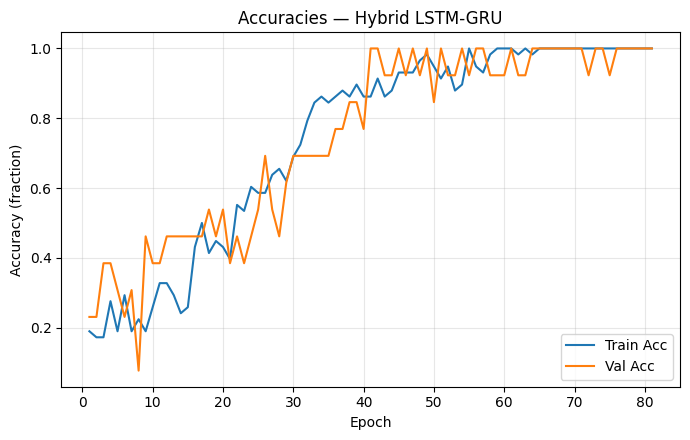

[plot] Saved: C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\LSTM-GRU\HybridLSTMGRU\20251010-030120\run5\loss_curve.png


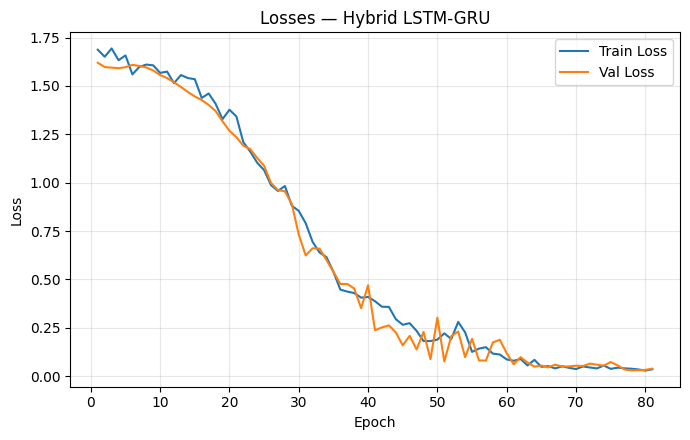

In [197]:
def _coerce_float_list(v):
    try:
        return [float(x) for x in (v if isinstance(v, (list, tuple)) else [])]
    except Exception:
        return []

def load_history_json(json_path):
    """Safe loader for train_history.json when you DO want to load from disk."""
    try:
        with open(json_path, "r") as f:
            hist = json.load(f)
        hist_out = {}
        for k in ("train_acc","val_acc","train_loss","val_loss"):
            hist_out[k] = _coerce_float_list(hist.get(k, []))
        return hist_out
    except Exception as e:
        print(f"[plot] Could not load history from {json_path}: {e}")
        return None

def plot_history(history=None, json_path=None, save_dir=None, title_suffix=""):
    """
    Plot accuracy & loss using decimals (0..1). Prefer `history` (in-memory).
    If `history` is None, tries to load from `json_path`.
    Titles have no run IDs.
    """
    if history is None:
        history = load_history_json(json_path)
    if not history:
        print("[plot] No history found to plot.")
        return

    train_acc = _coerce_float_list(history.get("train_acc"))
    val_acc   = _coerce_float_list(history.get("val_acc"))
    train_ls  = _coerce_float_list(history.get("train_loss"))
    val_ls    = _coerce_float_list(history.get("val_loss"))

    n = max(len(train_acc), len(val_acc), len(train_ls), len(val_ls))
    if n == 0:
        print("[plot] History lists are empty.")
        return
    epochs = list(range(1, n+1))

    def _pad(arr, n):
        arr = list(arr)
        if len(arr) < n:
            arr = arr + [np.nan]*(n-len(arr))
        return arr[:n]

    train_acc = _pad(train_acc, n)
    val_acc   = _pad(val_acc,   n)
    train_ls  = _pad(train_ls,  n)
    val_ls    = _pad(val_ls,    n)

    # --- Accuracy ---
    plt.figure(figsize=(7,4.5))
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, val_acc,   label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (fraction)")
    plt.title("Accuracies" + (f" — {title_suffix}" if title_suffix else ""))
    plt.grid(True, alpha=0.3); plt.legend(loc="lower right")
    if save_dir:
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        acc_path = str(Path(save_dir) / "acc_curve.png")
        plt.tight_layout(); plt.savefig(acc_path, dpi=150)
        print("[plot] Saved:", acc_path)
    plt.show()

    # --- Loss ---
    plt.figure(figsize=(7,4.5))
    plt.plot(epochs, train_ls, label="Train Loss")
    plt.plot(epochs, val_ls,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("Losses" + (f" — {title_suffix}" if title_suffix else ""))
    plt.grid(True, alpha=0.3); plt.legend(loc="upper right")
    if save_dir:
        loss_path = str(Path(save_dir) / "loss_curve.png")
        plt.tight_layout(); plt.savefig(loss_path, dpi=150)
        print("[plot] Saved:", loss_path)
    plt.show()

cands = glob.glob(os.path.join(CONFIG["EXPORT_DIR"], "run*", "train_history.json"))
if not cands:
    print("[plot] No train_history.json found under", CONFIG["EXPORT_DIR"])
else:
    json_path = max(cands, key=os.path.getmtime)
    save_dir  = os.path.dirname(json_path)
    print("[plot] Using history:", json_path)
    plot_history(history=None, json_path=json_path, save_dir=save_dir, title_suffix="Hybrid LSTM-GRU")

[eval] Loaded checkpoint: run5.pt (run 5)
TTA Test Accuracy: 92.31%


<Figure size 650x600 with 0 Axes>

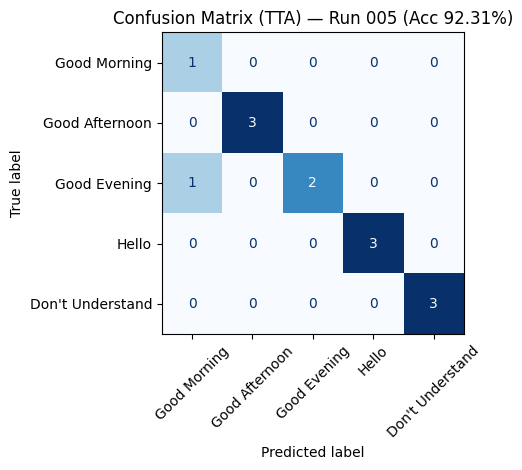

Test Acc 95% CI (Wilson): 66.69% .. 98.63%

Classification report:

                  precision    recall  f1-score   support

    Good Morning      0.500     1.000     0.667         1
  Good Afternoon      1.000     1.000     1.000         3
    Good Evening      1.000     0.667     0.800         3
           Hello      1.000     1.000     1.000         3
Don't Understand      1.000     1.000     1.000         3

        accuracy                          0.923        13
       macro avg      0.900     0.933     0.893        13
    weighted avg      0.962     0.923     0.928        13

Saved confusion matrix to: C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\LSTM-GRU\HybridLSTMGRU\20251010-030120\cm_tta_run005.png


In [198]:
def latest_ckpt(best_dir, prefix="run", ext=".pt"):
    best_dir = Path(best_dir)
    if not best_dir.exists():
        return None, None
    cand = []
    for f in best_dir.iterdir():
        if f.is_file():
            m = re.match(rf"^{re.escape(prefix)}(\d+){re.escape(ext)}$", f.name)
            if m:
                cand.append((int(m.group(1)), f))
    if not cand:
        return None, None
    cand.sort(key=lambda t: t[0])
    return cand[-1]  # (run_id, Path)

run_id, ckpt_path = latest_ckpt(CONFIG["BEST_DIR"], prefix="run", ext=".pt")
assert ckpt_path is not None, f"No checkpoint like 'runN.pt' found under {CONFIG['BEST_DIR']}"

ckpt = torch.load(str(ckpt_path), map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()
print(f"[eval] Loaded checkpoint: {ckpt_path.name} (run {run_id})")


def _tta_variants(x_np, n_nonflip=3, do_flip=False):
    T, D = x_np.shape
    FEAT = 126; has_flags = (D>=128)
    coords = x_np[:, :FEAT].reshape(T,42,3).copy()
    flags  = x_np[:, FEAT:FEAT+2].copy() if has_flags else None
    def pack(c,f): 
        flat = c.reshape(T,FEAT)
        return np.concatenate([flat,f],1) if has_flags else flat
    outs = [x_np.astype(np.float32)]
    for _ in range(n_nonflip):
        c = coords.copy()
        ang = np.deg2rad(np.random.uniform(-5,5))
        ca,sa = np.cos(ang), np.sin(ang)
        R = np.array([[ca,-sa],[sa,ca]], np.float32)
        xy = c[...,:2].reshape(-1,2) @ R.T
        c[...,:2] = xy.reshape(T,42,2)
        s = np.random.uniform(0.97,1.05)
        c *= np.array([s,s,1.0], np.float32)
        outs.append(pack(c, flags))
    return outs

all_preds, all_labels = [], []
with torch.no_grad():
    for x, lens, y, _paths in test_loader:
        B, T, D = x.shape
        x_np = x.cpu().numpy(); y_np = y.cpu().numpy()
        logits_sum = torch.zeros((B, len(CONFIG["CLASSES"])), device=device)
        for b in range(B):
            for v in _tta_variants(x_np[b], n_nonflip=3, do_flip=False):
                v_t = torch.from_numpy(v).to(device).float().unsqueeze(0)
                logits_sum[b] += model(v_t).squeeze(0)
        pred = logits_sum.argmax(1).cpu().numpy()
        all_preds.append(pred); all_labels.append(y_np)

all_preds  = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
test_acc = (all_preds == all_labels).mean() * 100.0
print(f"TTA Test Accuracy: {test_acc:.2f}%")

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels_names = CONFIG["CLASSES"]
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(labels_names))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
plt.figure(figsize=(6.5,6))
disp.plot(cmap="Blues", xticks_rotation=45, colorbar=False, values_format='d')
plt.title(f"Confusion Matrix (TTA) — Run {run_id:03d} (Acc {test_acc:.2f}%)")
plt.tight_layout()
cm_path = str(Path(CONFIG["EXPORT_DIR"]) / f"cm_tta_run{run_id:03d}.png")
plt.savefig(cm_path, dpi=150); plt.show()

from math import sqrt
n = len(all_labels); p = (test_acc/100.0); z = 1.96
den = 1 + z*z/n
center = (p + z*z/(2*n)) / den
half = z*sqrt((p*(1-p)/n) + (z*z/(4*n*n))) / den
print(f"Test Acc 95% CI (Wilson): {(center-half)*100:.2f}% .. {(center+half)*100:.2f}%")
print("\nClassification report:\n")
print(classification_report(all_labels, all_preds, target_names=labels_names, digits=3))
print("Saved confusion matrix to:", cm_path)

# TO CHECK TEST PT


Eval @ run1.pt | Test Accuracy: 0.9231


<Figure size 650x600 with 0 Axes>

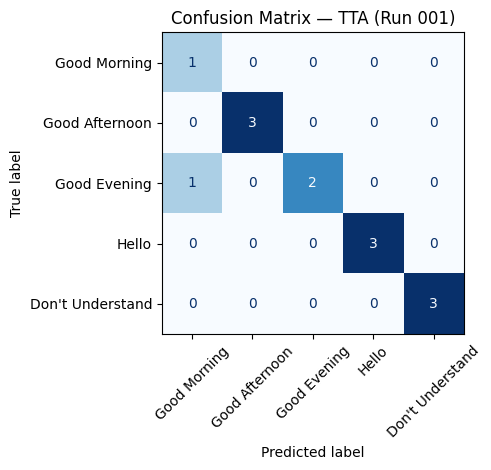

Saved: C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\LSTM-GRU\HybridLSTMGRU\20251010-030120\cm_tta_run001.png
Saved: C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\LSTM-GRU\HybridLSTMGRU\20251010-030120\acc_curve_run001.png


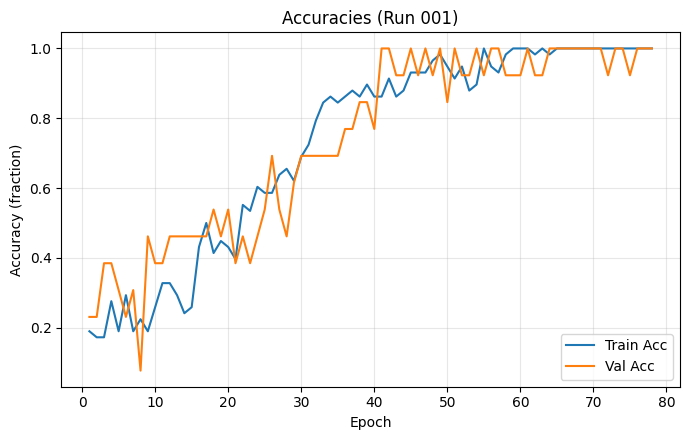

Saved: C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\LSTM-GRU\HybridLSTMGRU\20251010-030120\loss_curve_run001.png


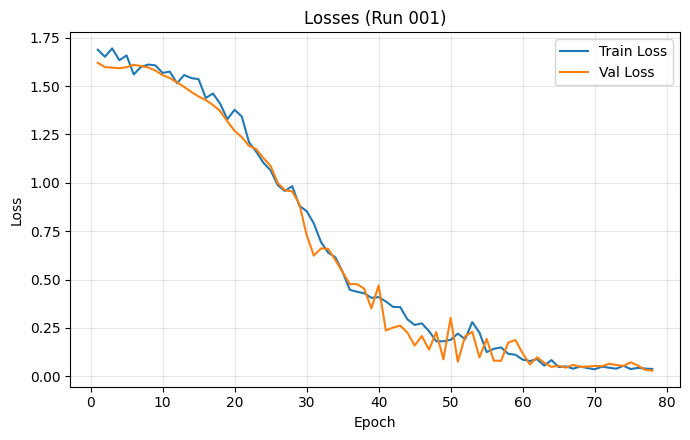

In [199]:
def load_model_from_path(model, path):
    path = str(path)
    state = torch.load(path, map_location=device)
    if isinstance(state, dict) and "model_state_dict" in state:
        model.load_state_dict(state["model_state_dict"])
        history = state.get("history", None)   # may be None
    else:
        model.load_state_dict(state if isinstance(state, dict) else state)
        history = None
    model.eval()
    return history

@torch.no_grad()
def test_with_tta(model, loader, classes, n_nonflip=3, do_flip=False):
    model.eval()
    all_preds, all_labels = [], []

    def _tta_variants(x_np, n_nonflip=3, do_flip=False):
        T, D = x_np.shape
        FEAT_COORDS = 126
        has_flags = (D >= 128)
        coords = x_np[:, :FEAT_COORDS].reshape(T, 42, 3).copy()
        flags  = x_np[:, FEAT_COORDS:FEAT_COORDS+2].copy() if has_flags else None

        def clamp(a): return np.clip(a, -5.0, 5.0).astype(np.float32)
        def pack(c, f):
            flat = c.reshape(T, FEAT_COORDS)
            return np.concatenate([flat, f], axis=1) if has_flags else flat

        outs = [x_np.astype(np.float32)]

        # non-flip augs
        for _ in range(n_nonflip):
            c = coords.copy()
            ang = np.deg2rad(np.random.uniform(-6, 6))
            ca, sa = np.cos(ang), np.sin(ang)
            R = np.array([[ca, -sa], [sa, ca]], np.float32)
            xy = c[..., :2].reshape(-1, 2) @ R.T
            c[..., :2] = xy.reshape(T, 42, 2)
            s = np.random.uniform(0.95, 1.05)
            c *= np.array([s, s, 1.0], np.float32)
            c[..., 0] += np.random.uniform(-0.02, 0.02)
            c[..., 1] += np.random.uniform(-0.02, 0.02)
            outs.append(pack(clamp(c), flags if flags is not None else None))

        if do_flip:
            c = coords.copy()
            c[..., 0] *= -1.0
            left  = c[:, :21, :].copy()
            right = c[:, 21:, :].copy()
            c[:, :21, :] = right
            c[:, 21:, :] = left
            f = flags.copy() if flags is not None else None
            if f is not None:
                f = f[:, ::-1]
            outs.append(pack(clamp(c), f))

        return outs

    for x, lens, y, _paths in loader:
        x = x.to(device).float()
        y = y.to(device).long()
        B, T, D = x.shape
        x_np = x.cpu().numpy()
        logits_sum = torch.zeros((B, len(classes)), device=device)

        for b in range(B):
            for v in _tta_variants(x_np[b], n_nonflip=n_nonflip, do_flip=do_flip):
                out = model(torch.from_numpy(v).to(device).float().unsqueeze(0))  # [1,C]
                logits_sum[b] += out.squeeze(0)

        pred = logits_sum.argmax(dim=1)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(y.cpu().numpy())

    all_preds  = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    acc = (all_preds == all_labels).mean()

    cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(classes))))
    return acc, cm, all_preds, all_labels

def plot_confusion_matrix(cm, classes, title, save_path=None):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    plt.figure(figsize=(6.5, 6))
    disp.plot(cmap="Blues", xticks_rotation=45, colorbar=False, values_format='d')
    plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

def plot_history_from_checkpoint_or_json(history, json_path=None, save_dir=None, run_ver=None):
    if history is None and json_path is not None and os.path.isfile(json_path):
        with open(json_path, "r") as f:
            history = json.load(f)

    if history is None:
        print("No history found in checkpoint and no valid JSON path provided.")
        return

    train_acc = history.get("train_acc", [])
    val_acc   = history.get("val_acc", [])
    train_loss= history.get("train_loss", [])
    val_loss  = history.get("val_loss", [])
    epochs    = list(range(1, max(len(train_acc), len(val_acc), len(train_loss), len(val_loss)) + 1))

    # Accuracy (FRACTIONS, not %)
    plt.figure(figsize=(7,4.5))
    if train_acc: plt.plot(epochs[:len(train_acc)], train_acc, label="Train Acc")
    if val_acc:   plt.plot(epochs[:len(val_acc)],   val_acc,   label="Val Acc")
    plt.title(f"Accuracies (Run {run_ver:03d})" if run_ver is not None else "Accuracies")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (fraction)")
    plt.grid(True, alpha=0.3); plt.legend(loc="lower right")
    if save_dir:
        ap = str(Path(save_dir) / f"acc_curve_run{run_ver:03d}.png") if run_ver is not None else str(Path(save_dir) / "acc_curve.png")
        plt.tight_layout(); plt.savefig(ap, dpi=150)
        print("Saved:", ap)
    plt.show()

    # Loss
    plt.figure(figsize=(7,4.5))
    if train_loss: plt.plot(epochs[:len(train_loss)], train_loss, label="Train Loss")
    if val_loss:   plt.plot(epochs[:len(val_loss)],   val_loss,   label="Val Loss")
    plt.title(f"Losses (Run {run_ver:03d})" if run_ver is not None else "Losses")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.grid(True, alpha=0.3); plt.legend(loc="upper right")
    if save_dir:
        lp = str(Path(save_dir) / f"loss_curve_run{run_ver:03d}.png") if run_ver is not None else str(Path(save_dir) / "loss_curve.png")
        plt.tight_layout(); plt.savefig(lp, dpi=150)
        print("Saved:", lp)
    plt.show()

def evaluate_checkpoint_or_weights(model_path,
                                   use_tta=True,
                                   n_nonflip=3,
                                   do_flip=False,
                                   save_dir=None,
                                   run_ver=None):
    """
    model_path: path to .pth (weights) or .pt (checkpoint)
    """
    # 1) Load
    hist_in_ckpt = load_model_from_path(model, model_path)

    # 2) Test (with or without TTA)
    if use_tta:
        acc, cm, preds, labels = test_with_tta(model, test_loader, CONFIG["CLASSES"],
                                               n_nonflip=n_nonflip, do_flip=do_flip)
    else:
        acc, cm, preds, labels = test_with_tta(model, test_loader, CONFIG["CLASSES"],
                                               n_nonflip=0, do_flip=False)

    print(f"\nEval @ {Path(model_path).name} | Test Accuracy: {acc:.4f}")
    cm_title = f"Confusion Matrix — {'TTA' if use_tta else 'No TTA'} (Run {run_ver:03d})" if run_ver is not None else "Confusion Matrix"
    cm_path = None
    if save_dir:
        cm_path = str(Path(save_dir) / (f"cm_tta_run{run_ver:03d}.png" if use_tta and run_ver is not None else "cm_eval.png"))
    plot_confusion_matrix(cm, CONFIG["CLASSES"], cm_title, save_path=cm_path)
    if cm_path: print("Saved:", cm_path)

    # 3) Curves
    # First try history from checkpoint; if not present, try your JSON in EXPORT_DIR
    json_fallback = str(Path(CONFIG["EXPORT_DIR"]) / f"train_history_run{RUN_VER:03d}.json")
    plot_history_from_checkpoint_or_json(hist_in_ckpt, json_path=json_fallback, save_dir=save_dir, run_ver=RUN_VER)

    return acc, cm, preds, labels

acc, cm, preds, labels = evaluate_checkpoint_or_weights(
    model_path=r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\LSTMGRUHybrid_best\run1.pt",
    use_tta=True, n_nonflip=3, do_flip=False,
    save_dir=CONFIG["EXPORT_DIR"], run_ver=RUN_VER
)

PLAIN Test Accuracy (no TTA): 92.31%


<Figure size 650x600 with 0 Axes>

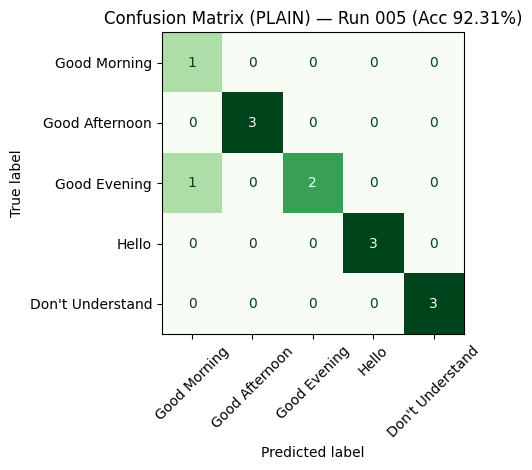

Saved plain confusion matrix to: C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\LSTM-GRU\HybridLSTMGRU\20251010-030120\cm_plain_run005.png

Classification report (PLAIN):

                  precision    recall  f1-score   support

    Good Morning      0.500     1.000     0.667         1
  Good Afternoon      1.000     1.000     1.000         3
    Good Evening      1.000     0.667     0.800         3
           Hello      1.000     1.000     1.000         3
Don't Understand      1.000     1.000     1.000         3

        accuracy                          0.923        13
       macro avg      0.900     0.933     0.893        13
    weighted avg      0.962     0.923     0.928        13

TTA Test Accuracy: 92.31%


In [201]:
# --------- PLAIN (no TTA) TEST ACCURACY ---------
import numpy as np, torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pathlib import Path

labels_names = CONFIG["CLASSES"]

all_preds_plain, all_labels_plain = [], []
with torch.no_grad():
    for x, lens, y, _paths in test_loader:
        x = x.to(device).float()
        y = y.to(device).long()
        logits = model(x)                    # single pass, no TTA
        pred = logits.argmax(1).cpu().numpy()
        all_preds_plain.append(pred)
        all_labels_plain.append(y.cpu().numpy())

all_preds_plain  = np.concatenate(all_preds_plain)
all_labels_plain = np.concatenate(all_labels_plain)
plain_acc = (all_preds_plain == all_labels_plain).mean() * 100.0
print(f"PLAIN Test Accuracy (no TTA): {plain_acc:.2f}%")

cm_plain = confusion_matrix(all_labels_plain, all_preds_plain,
                            labels=list(range(len(labels_names))))
disp_plain = ConfusionMatrixDisplay(confusion_matrix=cm_plain, display_labels=labels_names)
plt.figure(figsize=(6.5,6))
disp_plain.plot(cmap="Greens", xticks_rotation=45, colorbar=False, values_format='d')
plt.title(f"Confusion Matrix (PLAIN) — Run {run_id:03d} (Acc {plain_acc:.2f}%)")
plt.tight_layout()
cm_plain_path = str(Path(CONFIG["EXPORT_DIR"]) / f"cm_plain_run{run_id:03d}.png")
plt.savefig(cm_plain_path, dpi=150); plt.show()
print("Saved plain confusion matrix to:", cm_plain_path)

print("\nClassification report (PLAIN):\n")
print(classification_report(all_labels_plain, all_preds_plain,
                            target_names=labels_names, digits=3))

# --------- TTA TEST ACCURACY (your current method) ---------
def _tta_variants(x_np, n_nonflip=3, do_flip=False):
    T, D = x_np.shape
    FEAT = 126; has_flags = (D>=128)
    coords = x_np[:, :FEAT].reshape(T,42,3).copy()
    flags  = x_np[:, FEAT:FEAT+2].copy() if has_flags else None
    def pack(c,f):
        flat = c.reshape(T,FEAT)
        return np.concatenate([flat,f],1) if has_flags else flat
    outs = [x_np.astype(np.float32)]
    for _ in range(n_nonflip):
        c = coords.copy()
        ang = np.deg2rad(np.random.uniform(-5,5))
        ca,sa = np.cos(ang), np.sin(ang)
        R = np.array([[ca,-sa],[sa,ca]], np.float32)
        xy = c[...,:2].reshape(-1,2) @ R.T
        c[...,:2] = xy.reshape(T,42,2)
        s = np.random.uniform(0.97,1.05)
        c *= np.array([s,s,1.0], np.float32)
        outs.append(pack(c, flags))
    return outs

all_preds_tta, all_labels_tta = [], []
with torch.no_grad():
    for x, lens, y, _paths in test_loader:
        B, T, D = x.shape
        x_np = x.cpu().numpy(); y_np = y.cpu().numpy()
        logits_sum = torch.zeros((B, len(CONFIG["CLASSES"])), device=device)
        for b in range(B):
            for v in _tta_variants(x_np[b], n_nonflip=3, do_flip=False):
                v_t = torch.from_numpy(v).to(device).float().unsqueeze(0)
                logits_sum[b] += model(v_t).squeeze(0)
        pred = logits_sum.argmax(1).cpu().numpy()
        all_preds_tta.append(pred); all_labels_tta.append(y_np)

all_preds_tta  = np.concatenate(all_preds_tta)
all_labels_tta = np.concatenate(all_labels_tta)
tta_acc = (all_preds_tta == all_labels_tta).mean() * 100.0
print(f"TTA Test Accuracy: {tta_acc:.2f}%")


# Testing

In [210]:
CLASSES = ["Good Morning", "Good Afternoon", "Good Evening", "Hello", "Don't Understand"]
# NEVER ADJUST
SEQUENCE_LENGTH = 48
FEATURE_DIM     = 126 + 2       # 42*3 + [left_present, right_present]
USE_HANDS_ONLY  = True          # we use MediaPipe Hands
INVERT_HANDEDNESS = True        # match training/extraction
MIN_PALM_SCALE  = 0.02
CLIP_COORD      = 5.0

# SAFE TO ADJUST
FRAME_STRIDE   = 3              # process every Nth frame
MAX_CARRY      = 0              # carry last detection a few frames
CARRY_NOISE    = 0.003          # tiny jitter for carried coords
EMA_ALPHA      = 0.50           # logits smoothing
BASE_THRESH    = 0.90           # acceptance threshold
PER_CLASS_THRESH = {            # optional per-class overrides
    # "Good Evening": 0.85,
}
N_CONSEC       = 16              # frames above threshold to confirm
SHOW_FPS       = True
PRESENT_RATIO_MIN = 0.55

# ---- Where your trained weights live (as saved by your training Cell 7) ----
BEST_DIR = r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\LSTMGRUHybrid_best"

# ---- MediaPipe params (match your extraction) ----
MIN_DET_CONF   = 0.7
MIN_TRACK_CONF = 0.7
MODEL_COMPLEXITY = 1

# ---- Torch device ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [211]:
# === Cell 2: Live feature extraction helpers (no dataset sweep) ===
import mediapipe as mp
mp_hands = mp.solutions.hands

def get_detector():
    return mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=2,
        model_complexity=MODEL_COMPLEXITY,
        min_detection_confidence=MIN_DET_CONF,
        min_tracking_confidence=MIN_TRACK_CONF
    )

def normalize_hand(pts: np.ndarray) -> np.ndarray:
    # pts: (21,3); wrist-center, scale by wrist->middle finger MCP (id=9), clamp
    if pts is None or pts.shape != (21,3):
        return np.zeros((21,3), np.float32)
    wrist, mid = pts[0], pts[9]
    scale = float(np.linalg.norm(mid[:2] - wrist[:2]))
    if not np.isfinite(scale) or scale < MIN_PALM_SCALE:
        scale = MIN_PALM_SCALE
    out = (pts - wrist) / scale
    return np.clip(out, -CLIP_COORD, CLIP_COORD).astype(np.float32)

def pack_feature(L_pts, R_pts, lf, rf) -> np.ndarray:
    L = normalize_hand(L_pts)
    R = normalize_hand(R_pts)
    feat = np.concatenate([L.reshape(-1), R.reshape(-1)], axis=0)  # 126
    feat = np.concatenate([feat, np.array([lf, rf], dtype=np.float32)], axis=0)  # +2 flags
    return feat.astype(np.float32)

def get_lr_pts(res):
    """
    Return (L, R) hand arrays of shape (21,3) or None, honoring INVERT_HANDEDNESS.
    For MediaPipe Hands: use handedness labels if available; fallback to index order.
    """
    if res is None or not getattr(res, "multi_hand_landmarks", None):
        return None, None

    L, R = None, None
    handed = getattr(res, "multi_handedness", None)
    if handed and len(handed) == len(res.multi_hand_landmarks):
        for lm, hd in zip(res.multi_hand_landmarks, handed):
            label = hd.classification[0].label if hd.classification else "Right"
            if INVERT_HANDEDNESS:
                label = "Left" if label == "Right" else "Right"
            pts = np.array([[p.x, p.y, p.z] for p in lm.landmark], dtype=np.float32)
            if label == "Left": L = pts
            else: R = pts
    else:
        # Fallback by order
        lms = res.multi_hand_landmarks
        if len(lms) >= 1:
            pts0 = np.array([[p.x, p.y, p.z] for p in lms[0].landmark], dtype=np.float32)
            if INVERT_HANDEDNESS: L = pts0
            else: R = pts0
        if len(lms) >= 2:
            pts1 = np.array([[p.x, p.y, p.z] for p in lms[1].landmark], dtype=np.float32)
            if INVERT_HANDEDNESS: R = pts1
            else: L = pts1
    return L, R

def softmax_np(x):
    x = x - np.max(x)
    e = np.exp(x)
    return e / np.sum(e)

def get_threshold(cls_idx):
    name = CLASSES[cls_idx]
    return PER_CLASS_THRESH.get(name, BASE_THRESH)

In [212]:
# === Cell 2.A: Live preview to confirm detection (hands, flags, inversion) ===
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_styles  = mp.solutions.drawing_styles

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("Cannot open camera")

present_history = []   # keep a short log of present ratio
HIST_N = 30

with get_detector() as detector:
    while True:
        ok, frame = cap.read()
        if not ok:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb.flags.writeable = False
        try:
            res = detector.process(rgb)
        except Exception:
            res = None

        L_pts, R_pts = get_lr_pts(res)
        lf = 1.0 if L_pts is not None else 0.0
        rf = 1.0 if R_pts is not None else 0.0
        present_ratio = 1.0 if (lf + rf) > 0 else 0.0
        present_history.append(present_ratio)
        if len(present_history) > HIST_N:
            present_history.pop(0)

        # draw landmarks if we have them
        hud = frame.copy()
        H, W = hud.shape[:2]
        if getattr(res, "multi_hand_landmarks", None):
            for lm in res.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    hud,
                    lm,
                    mp_hands.HAND_CONNECTIONS,
                    mp_styles.get_default_hand_landmarks_style(),
                    mp_styles.get_default_hand_connections_style()
                )

        # top banner
        cv2.rectangle(hud, (0,0), (W, 80), (25,25,25), -1)
        cv2.putText(hud, "Live Detection Preview (Q to quit)", (10, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (230,230,230), 2, cv2.LINE_AA)

        # show flags + which side is which
        txt = f"L_present={int(lf)}   R_present={int(rf)}   (invert={INVERT_HANDEDNESS})"
        cv2.putText(hud, txt, (10, 55),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (90, 220, 255), 2, cv2.LINE_AA)

        # present ratio sparkline (last N frames)
        x0, y0 = 10, H - 20
        w_bar = 4
        for i, v in enumerate(present_history):
            h = int(30 * v)
            x = x0 + i*(w_bar+1)
            cv2.rectangle(hud, (x, y0-h), (x+w_bar, y0), (90,200,255), -1)
        cv2.putText(hud, f"present_ratio (last {HIST_N})", (x0, y0-35),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (230,230,230), 1, cv2.LINE_AA)

        # quick tip line
        tip = "Show each hand clearly; flip INVERT_HANDEDNESS if L/R labels feel swapped."
        cv2.putText(hud, tip, (10, H-60),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200,200,200), 1, cv2.LINE_AA)

        cv2.imshow("Hands Preview", hud)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

In [213]:
# === Cell 3: Model & checkpoint loading ===
class LSTMGRUHybrid(nn.Module):
    def __init__(self, input_size: int, num_classes: int,
                 lstm_hidden: int = 128,
                 gru_hidden:  int = 128,
                 fc_hidden:   int = 160,
                 dropout_p:   float = 0.20):
        super().__init__()
        self.lstm = nn.LSTM(input_size, lstm_hidden, num_layers=1, batch_first=True)
        self.bn_lstm = nn.LayerNorm(lstm_hidden)
        self.drop_lstm = nn.Dropout(dropout_p)

        self.gru  = nn.GRU(lstm_hidden, gru_hidden, num_layers=1, batch_first=True)
        self.bn_gru = nn.LayerNorm(gru_hidden)
        self.drop_gru = nn.Dropout(dropout_p)

        self.fc1 = nn.Linear(gru_hidden, fc_hidden)
        self.bn_fc1 = nn.LayerNorm(fc_hidden)
        self.drop_fc1 = nn.Dropout(dropout_p)

        self.fc_out = nn.Linear(fc_hidden, num_classes)
        self.act = nn.ReLU()

    def forward(self, x):                 # x: [B, T=48, D=128]
        lstm_out, _ = self.lstm(x)        # [B, T, H_lstm]
        lstm_out = self.bn_lstm(lstm_out)
        lstm_out = self.drop_lstm(lstm_out)

        gru_out, h_n = self.gru(lstm_out)
        h_last = h_n[-1]                  # [B, H_gru]
        h_last = self.bn_gru(h_last)
        h_last = self.drop_gru(self.act(h_last))

        z = self.fc1(h_last)
        z = self.bn_fc1(z)
        z = self.drop_fc1(self.act(z))
        return self.fc_out(z)

def find_latest_weights(best_dir):
    best = Path(best_dir)
    if not best.exists(): return None
    # prefer .pth (weights only), fallback .pt (checkpoint)
    pths, pts = [], []
    for f in best.iterdir():
        m = re.match(r"^run(\d+)\.pth$", f.name)
        if m: pths.append((int(m.group(1)), f))
    if pths:
        pths.sort(key=lambda t: t[0])
        return pths[-1][1], pths[-1][0], "pth"
    for f in best.iterdir():
        m = re.match(r"^run(\d+)\.pt$", f.name)
        if m: pts.append((int(m.group(1)), f))
    if pts:
        pts.sort(key=lambda t: t[0])
        return pts[-1][1], pts[-1][0], "pt"
    return None

model = LSTMGRUHybrid(128, len(CLASSES), dropout_p=0.20).to(device).eval()
found = find_latest_weights(BEST_DIR)
assert found is not None, f"No runN.pth/pt found in {BEST_DIR}"
wpath, run_id, kind = found
state = torch.load(str(wpath), map_location=device)
if kind == "pth":
    model.load_state_dict(state)
else:
    model.load_state_dict(state["model_state_dict"])
print(f"[INFO] Loaded {wpath.name} (run {run_id:03d})")


[INFO] Loaded run5.pth (run 005)


In [215]:
# === Cell 4: Real-time test (Correct / Wrong UI) ===
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("Cannot open camera")

target_idx = None   # chosen class (1..5 hotkeys)
consec_ok = 0
consec_wrong = 0

buf = np.zeros((SEQUENCE_LENGTH, FEATURE_DIM), np.float32)
have = 0
last_feat = None
carry = 0
idx = 0

ema_logits = None
t_last = time.time()
fps_smoothed = None

with get_detector() as detector:
    while True:
        ok, frame = cap.read()
        if not ok: break
        if (idx % FRAME_STRIDE) != 0:
            idx += 1
            continue
        idx += 1

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb.flags.writeable = False
        try:
            res = detector.process(rgb)
        except Exception:
            res = None

        L_pts, R_pts = get_lr_pts(res)
        lf = 1.0 if L_pts is not None else 0.0
        rf = 1.0 if R_pts is not None else 0.0
        detected = (lf + rf) > 0.0

        if detected:
            feat = pack_feature(L_pts, R_pts, lf, rf)
            last_feat = feat
            carry = 0
        else:
            if (last_feat is not None) and (carry < MAX_CARRY):
                feat = last_feat.copy()
                if CARRY_NOISE > 0:
                    noise = np.zeros_like(feat, dtype=np.float32)
                    noise[:126] = np.random.normal(0.0, CARRY_NOISE, size=126).astype(np.float32)
                    feat += noise
                carry += 1
            else:
                feat = np.zeros((FEATURE_DIM,), np.float32)

        # slide window
        if have < SEQUENCE_LENGTH:
            buf[have] = feat
            have += 1
        else:
            buf[:-1] = buf[1:]
            buf[-1]  = feat

        pred_name, pred_prob = "-", 0.0
        status = "No hands"
        color = (80, 80, 80)

        if have == SEQUENCE_LENGTH:
            x = torch.from_numpy(buf[None,:,:]).to(device).float()
            with torch.no_grad():
                logits = model(x).squeeze(0).cpu().numpy()

            # EMA smoothing
            if ema_logits is None:
                ema_logits = logits.copy()
            else:
                ema_logits = EMA_ALPHA*logits + (1.0-EMA_ALPHA)*ema_logits

            probs = softmax_np(ema_logits)
            pred_idx = int(np.argmax(probs))
            pred_prob = float(probs[pred_idx])
            pred_name = CLASSES[pred_idx]

            # presence gating: if almost no hands in window, skip decision
            flags = buf[:, 126:128]
            present_ratio = float((flags.sum(axis=1) > 0.0).mean())
            hands_ok = present_ratio > 0.25

            if hands_ok:
                thr = get_threshold(pred_idx)
                if target_idx is not None and pred_prob >= thr:
                    if pred_idx == target_idx:
                        consec_ok += 1; consec_wrong = 0
                    else:
                        consec_wrong += 1; consec_ok = 0
                else:
                    consec_ok = consec_wrong = 0

                # Decide status text
                if target_idx is not None:
                    if consec_ok >= N_CONSEC:
                        status = "✅ Correct"
                        color = (0, 200, 0)
                    elif consec_wrong >= N_CONSEC:
                        status = f"❌ Wrong (Looks like: {pred_name} {pred_prob:.2f})"
                        color = (0, 0, 220)
                    else:
                        status = f"{pred_name} ({pred_prob:.2f})"
                        color = (40, 180, 255) if pred_prob >= thr else (120,120,120)
                else:
                    status = f"{pred_name} ({pred_prob:.2f})"
                    color = (40, 180, 255) if pred_prob >= thr else (120,120,120)
            else:
                consec_ok = consec_wrong = 0
                status = "Show both hands clearly"
                color = (80, 80, 80)

        # ---- HUD ----
        hud = frame.copy()
        H, W = hud.shape[:2]
        cv2.rectangle(hud, (0,0), (W, 70), (25,25,25), -1)
        tgt_text = f"Target: {CLASSES[target_idx]}" if target_idx is not None else "Target: (none) [1-5 set, R random, C clear]"
        cv2.putText(hud, tgt_text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (230,230,230), 2, cv2.LINE_AA)
        cv2.putText(hud, status,   (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv2.LINE_AA)

        # probs bars
        if have == SEQUENCE_LENGTH and 'probs' in locals():
            x0, y0 = 10, H-10
            bar_w, bar_h = 220, 12
            gap = 6
            for i, name in enumerate(CLASSES):
                p = float(probs[i])
                y = y0 - i*(bar_h+gap)
                cv2.rectangle(hud, (x0, y-bar_h), (x0+bar_w, y), (40,40,40), -1)
                w = int(bar_w * p)
                cv2.rectangle(hud, (x0, y-bar_h), (x0+w, y), (90,200,255), -1)
                t = f"{name[:16]:16s} {p:0.2f}"
                cv2.putText(hud, t, (x0+bar_w+10, y-2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (230,230,230), 1, cv2.LINE_AA)

        if SHOW_FPS:
            t_now = time.time()
            fps = 1.0 / max(1e-6, (t_now - t_last))
            t_last = t_now
            fps_smoothed = fps if fps_smoothed is None else (0.8*fps_smoothed + 0.2*fps)
            cv2.putText(hud, f"{fps_smoothed:0.1f} FPS", (W-120, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (230,230,230), 2, cv2.LINE_AA)

        cv2.imshow("FSL Real-time", hud)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'): break
        if key in [ord('1'), ord('2'), ord('3'), ord('4'), ord('5')]:
            target_idx = int(chr(key)) - 1
            consec_ok = consec_wrong = 0
        if key in [ord('c'), ord('C')]:
            target_idx = None
            consec_ok = consec_wrong = 0
        if key in [ord('r'), ord('R')]:
            target_idx = random.randrange(len(CLASSES))
            consec_ok = consec_wrong = 0

cap.release()
cv2.destroyAllWindows()


In [235]:
# === Cell 4 (REPLACEMENT): Real-time test with guided UI (countdown + prompts) ===
import time, random, sys
try:
    import winsound  # Windows beep (optional)
    def _beep(freq=800, dur=120): 
        try: winsound.Beep(freq, dur)
        except: pass
except Exception:
    def _beep(freq=800, dur=120): 
        pass  # no-op on non-Windows

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("Cannot open camera")

# --- Small UI helpers ---
def draw_center_text(img, text, y, scale=1.0, color=(230,230,230), thick=2):
    W = img.shape[1]
    (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, scale, thick)
    x = (W - tw)//2
    cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, scale, color, thick, cv2.LINE_AA)

def draw_progress_bar(img, x0, y0, w, h, p, fg=(90,200,255), bg=(40,40,40)):
    p = max(0.0, min(1.0, float(p)))
    cv2.rectangle(img, (x0, y0), (x0+w, y0+h), bg, -1)
    cv2.rectangle(img, (x0, y0), (x0+int(w*p), y0+h), fg, -1)
    cv2.rectangle(img, (x0, y0), (x0+w, y0+h), (70,70,70), 1)

# --- States ---
STATE_READY     = 0  # target chosen, waiting for SPACE
STATE_COUNTDOWN = 1  # short prep (3..2..1)
STATE_ACTIVE    = 2  # user signing; system judging
STATE_RESULT    = 3  # show Correct/Wrong briefly

state = STATE_READY
COUNTDOWN_SEC = 2.0          # prep time before capture window
RESULT_HOLD_SEC = 1.5        # show result then reset
block_input_until = 0.0

# --- Your existing vars ---
target_idx = None   # chosen class (1..5 or R)
consec_ok = 0
consec_wrong = 0

buf = np.zeros((SEQUENCE_LENGTH, FEATURE_DIM), np.float32)
have = 0
last_feat = None
carry = 0
idx = 0

ema_logits = None
t_last = time.time()
fps_smoothed = None

countdown_end_time = None
result_end_time = None

with get_detector() as detector:
    while True:
        ok, frame = cap.read()
        if not ok: break
        if (idx % FRAME_STRIDE) != 0:
            idx += 1
            continue
        idx += 1

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb.flags.writeable = False
        try:
            res = detector.process(rgb)
        except Exception:
            res = None

        # --- feature pack (unchanged) ---
        L_pts, R_pts = get_lr_pts(res)
        lf = 1.0 if L_pts is not None else 0.0
        rf = 1.0 if R_pts is not None else 0.0
        detected = (lf + rf) > 0.0

        if detected:
            feat = pack_feature(L_pts, R_pts, lf, rf)
            last_feat = feat
            carry = 0
        else:
            if (last_feat is not None) and (carry < MAX_CARRY):
                feat = last_feat.copy()
                if CARRY_NOISE > 0:
                    noise = np.zeros_like(feat, dtype=np.float32)
                    noise[:126] = np.random.normal(0.0, CARRY_NOISE, size=126).astype(np.float32)
                    feat += noise
                carry += 1
            else:
                feat = np.zeros((FEATURE_DIM,), np.float32)

        # slide window
        if have < SEQUENCE_LENGTH:
            buf[have] = feat
            have += 1
        else:
            buf[:-1] = buf[1:]
            buf[-1]  = feat

        # --- default HUD ---
        hud = frame.copy()
        H, W = hud.shape[:2]

        # Header bar
        cv2.rectangle(hud, (0,0), (W, 70), (25,25,25), -1)
        tgt_text = f"Target: {CLASSES[target_idx]}" if target_idx is not None else \
                   "Target: (none) — press [1..5], R=random"
        cv2.putText(hud, tgt_text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (230,230,230), 2, cv2.LINE_AA)

        # Hand presence indicator (last window)
        flags_win = buf[:,126:128]
        present_ratio = float((flags_win.sum(axis=1) > 0.0).mean())
        cv2.putText(hud, f"Hands present: {present_ratio*100:0.0f}%", (W-260, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200,200,200), 2, cv2.LINE_AA)

        # Buffer fill
        draw_progress_bar(hud, 10, 45, 240, 12, have/SEQUENCE_LENGTH, fg=(120,220,120))
        cv2.putText(hud, "Buffer", (260, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (220,220,220), 1, cv2.LINE_AA)

        # FPS
        if SHOW_FPS:
            t_now = time.time()
            fps = 1.0 / max(1e-6, (t_now - t_last))
            t_last = t_now
            fps_smoothed = fps if fps_smoothed is None else (0.8*fps_smoothed + 0.2*fps)
            cv2.putText(hud, f"{fps_smoothed:0.1f} FPS", (W-120, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (230,230,230), 2, cv2.LINE_AA)

        # --- MODEL PRED ---
        probs = None; pred_idx = None; pred_prob = 0.0
        if have == SEQUENCE_LENGTH:
            x = torch.from_numpy(buf[None,:,:]).to(device).float()
            with torch.no_grad():
                logits = model(x).squeeze(0).cpu().numpy()

            if ema_logits is None: ema_logits = logits.copy()
            else: ema_logits = EMA_ALPHA*logits + (1.0-EMA_ALPHA)*ema_logits

            probs = softmax_np(ema_logits)
            pred_idx = int(np.argmax(probs))
            pred_prob = float(probs[pred_idx])
            pred_name = CLASSES[pred_idx]
        else:
            pred_name = "-"

        # --- STATE MACHINE ---
        now = time.time()

        if state == STATE_READY:
            # Instructions
            draw_center_text(hud, "Press SPACE to start", H//2 - 20, 1.0, (200,220,255), 2)
            draw_center_text(hud, "Choose a target first: [1..5], R=random", H//2 + 20, 0.8, (200,200,200), 2)
            if target_idx is not None:
                draw_center_text(hud, f"Target: {CLASSES[target_idx]}", H//2 + 55, 0.9, (230,230,230), 2)

        elif state == STATE_COUNTDOWN:
            secs_left = countdown_end_time - now
            if secs_left <= 0:
                state = STATE_ACTIVE
                consec_ok = consec_wrong = 0
                _beep(950, 120)  # GO beep
            else:
                n = int(secs_left)+1
                draw_center_text(hud, "Get ready...", H//2 - 40, 1.0, (255,225,180), 2)
                draw_center_text(hud, str(n), H//2 + 20, 2.0, (255,235,180), 3)

        elif state == STATE_ACTIVE:
            # Only judge when hands are mostly present
            hands_ok = present_ratio > 0.25 and probs is not None
            thr = get_threshold(pred_idx) if pred_idx is not None else BASE_THRESH
            if hands_ok and target_idx is not None and pred_idx is not None:
                if pred_prob >= thr:
                    if pred_idx == target_idx:
                        consec_ok += 1; consec_wrong = 0
                    else:
                        consec_wrong += 1; consec_ok = 0
                else:
                    consec_ok = consec_wrong = 0

                # progress towards decision
                need = N_CONSEC
                prog = max(consec_ok, consec_wrong) / max(1, need)
                draw_progress_bar(hud, (W-320)//2, 90, 320, 14, prog,
                                  fg=(0,200,0) if consec_ok>consec_wrong else (0,0,220))
                label = "Matching target..." if consec_ok>=consec_wrong else "Looks different..."
                draw_center_text(hud, label, 120, 0.8, (230,230,230), 2)

                status_line = f"Pred: {CLASSES[pred_idx]}  p={pred_prob:.2f}  thr={thr:.2f}"
                draw_center_text(hud, status_line, 150, 0.8, (200,220,255), 2)

                # bars
                if probs is not None:
                    x0, y0 = 10, H-10
                    bar_w, bar_h = 220, 12
                    gap = 6
                    for i, name in enumerate(CLASSES):
                        p = float(probs[i]); y = y0 - i*(bar_h+gap)
                        cv2.rectangle(hud, (x0, y-bar_h), (x0+bar_w, y), (40,40,40), -1)
                        cv2.rectangle(hud, (x0, y-bar_h), (x0+int(bar_w*p), y), (90,200,255), -1)
                        t = f"{name[:16]:16s} {p:0.2f}"
                        cv2.putText(hud, t, (x0+bar_w+10, y-2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (230,230,230), 1, cv2.LINE_AA)

                if consec_ok >= N_CONSEC:
                    state = STATE_RESULT
                    result_ok = True
                    result_text = "✅ Correct"
                    result_color = (0, 200, 0)
                    result_end_time = now + RESULT_HOLD_SEC
                    _beep(1000, 120)
                elif consec_wrong >= N_CONSEC:
                    state = STATE_RESULT
                    result_ok = False
                    guess = CLASSES[pred_idx]
                    result_text = f"❌ Wrong (Looks like: {guess})"
                    result_color = (0, 0, 220)
                    result_end_time = now + RESULT_HOLD_SEC
                    _beep(450, 150)
            else:
                draw_center_text(hud, "Sign now!", 120, 1.0, (255,255,180), 2)
                draw_center_text(hud, "Show both hands clearly", 150, 0.8, (200,200,200), 2)

        elif state == STATE_RESULT:
            draw_center_text(hud, result_text, H//2, 1.2, result_color, 3)
            if now >= result_end_time:
                # reset for next round
                state = STATE_READY
                consec_ok = consec_wrong = 0

        # --- Show window ---
        cv2.imshow("FSL Real-time (Guided)", hud)

        # --- Keyboard ---
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'): 
            break
        if key in [ord('1'), ord('2'), ord('3'), ord('4'), ord('5')]:
            target_idx = int(chr(key)) - 1
            consec_ok = consec_wrong = 0
            state = STATE_READY
        if key in [ord('r'), ord('R')]:
            target_idx = random.randrange(len(CLASSES))
            consec_ok = consec_wrong = 0
            state = STATE_READY
        if key == ord('c') or key == ord('C'):
            target_idx = None
            consec_ok = consec_wrong = 0
            state = STATE_READY
        if key == ord(' '):  # SPACE to start
            if target_idx is not None and state in (STATE_READY, STATE_RESULT):
                countdown_end_time = time.time() + COUNTDOWN_SEC
                state = STATE_COUNTDOWN
                _beep(700, 120)

cap.release()
cv2.destroyAllWindows()


# BERSYON 2

In [226]:
CLASSES = ["Good Morning", "Good Afternoon", "Good Evening", "Hello", "Don't Understand"]

# ---- Core feature shape (must match training/extraction) ----
SEQUENCE_LENGTH = 48
FEATURE_DIM     = 126 + 2       # 42*3 + [left_present, right_present]
USE_HANDS_ONLY  = True
INVERT_HANDEDNESS = True
MIN_PALM_SCALE  = 0.02
CLIP_COORD      = 5.0

# ---- Real-time behavior (tuned to avoid early decisions) ----
FRAME_STRIDE = 3        # wider coverage per 48 frames (slower but steadier)
MAX_CARRY    = 0        # don't hold stale detections
CARRY_NOISE  = 0.003

EMA_ALPHA    = 0.50     # heavier smoothing
BASE_THRESH  = 0.88     # a bit easier than 0.90
PER_CLASS_THRESH = {
    # "Good Evening": 0.90,
}
N_CONSEC     = 12       # was 16 → fewer sustained frames needed

# New gates for better UX
MIN_JUDGE_SEC       = 0.8   # default grace (used for SPACE flow)
SIGN_GRACE_SEC_S    = 3.0   # grace if started with 'S' (no judging for 3s)
PRESENT_RATIO_MIN   = 0.40  # was 0.55 → allow partial visibility
MOTION_MEAN_MIN     = 0.10  # was 0.12 → slightly easier

SHOW_FPS = True

# ---- Where your trained weights live ----
BEST_DIR = r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\LSTMGRUHybrid_best"

# ---- MediaPipe params (match extraction) ----
MIN_DET_CONF   = 0.7
MIN_TRACK_CONF = 0.7
MODEL_COMPLEXITY = 1

# ---- Torch device ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Safety asserts
assert SEQUENCE_LENGTH == 48
assert FEATURE_DIM == 128


Using device: cuda


In [227]:
import mediapipe as mp
mp_hands = mp.solutions.hands

def get_detector():
    return mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=2,
        model_complexity=MODEL_COMPLEXITY,
        min_detection_confidence=MIN_DET_CONF,
        min_tracking_confidence=MIN_TRACK_CONF
    )

def normalize_hand(pts: np.ndarray) -> np.ndarray:
    # pts: (21,3); wrist-center, scale by wrist->middle finger MCP (id=9), clamp
    if pts is None or pts.shape != (21,3):
        return np.zeros((21,3), np.float32)
    wrist, mid = pts[0], pts[9]
    scale = float(np.linalg.norm(mid[:2] - wrist[:2]))
    if not np.isfinite(scale) or scale < MIN_PALM_SCALE:
        scale = MIN_PALM_SCALE
    out = (pts - wrist) / scale
    return np.clip(out, -CLIP_COORD, CLIP_COORD).astype(np.float32)

def pack_feature(L_pts, R_pts, lf, rf) -> np.ndarray:
    L = normalize_hand(L_pts)
    R = normalize_hand(R_pts)
    feat = np.concatenate([L.reshape(-1), R.reshape(-1)], axis=0)  # 126
    feat = np.concatenate([feat, np.array([lf, rf], dtype=np.float32)], axis=0)  # +2 flags
    return feat.astype(np.float32)

def get_lr_pts(res):
    """
    Return (L, R) hand arrays of shape (21,3) or None, honoring INVERT_HANDEDNESS.
    Uses handedness labels if available; otherwise falls back to order.
    """
    if res is None or not getattr(res, "multi_hand_landmarks", None):
        return None, None

    L, R = None, None
    handed = getattr(res, "multi_handedness", None)
    if handed and len(handed) == len(res.multi_hand_landmarks):
        for lm, hd in zip(res.multi_hand_landmarks, handed):
            label = hd.classification[0].label if hd.classification else "Right"
            if INVERT_HANDEDNESS:
                label = "Left" if label == "Right" else "Right"
            pts = np.array([[p.x, p.y, p.z] for p in lm.landmark], dtype=np.float32)
            if label == "Left": L = pts
            else: R = pts
    else:
        lms = res.multi_hand_landmarks
        if len(lms) >= 1:
            pts0 = np.array([[p.x, p.y, p.z] for p in lms[0].landmark], dtype=np.float32)
            if INVERT_HANDEDNESS: L = pts0
            else: R = pts0
        if len(lms) >= 2:
            pts1 = np.array([[p.x, p.y, p.z] for p in lms[1].landmark], dtype=np.float32)
            if INVERT_HANDEDNESS: R = pts1
            else: L = pts1
    return L, R

def softmax_np(x):
    x = x - np.max(x)
    e = np.exp(x)
    return e / np.sum(e)

def get_threshold(cls_idx):
    name = CLASSES[cls_idx]
    return PER_CLASS_THRESH.get(name, BASE_THRESH)

# --- New: motion gate helper (mean normalized motion over the 48-frame window) ---
def motion_mag_window(buf_48x128: np.ndarray) -> float:
    coords = buf_48x128[:, :126].reshape(SEQUENCE_LENGTH, 42, 3)
    if coords.shape[0] < 2: return 0.0
    v = coords[1:] - coords[:-1]
    m = np.linalg.norm(v.reshape(v.shape[0], -1), axis=1)
    mm = m.max()
    if mm <= 1e-6:
        return 0.0
    return float((m / mm).mean())


In [228]:
# === Cell 2.A: Live preview to confirm detection (optional) ===
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_styles  = mp.solutions.drawing_styles

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("Cannot open camera")

present_history = []
HIST_N = 30

with get_detector() as detector:
    while True:
        ok, frame = cap.read()
        if not ok: break
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB); rgb.flags.writeable = False
        try: res = detector.process(rgb)
        except Exception: res = None

        L_pts, R_pts = get_lr_pts(res)
        lf = 1.0 if L_pts is not None else 0.0
        rf = 1.0 if R_pts is not None else 0.0
        present_ratio = 1.0 if (lf + rf) > 0 else 0.0
        present_history.append(present_ratio)
        if len(present_history) > HIST_N: present_history.pop(0)

        hud = frame.copy(); H, W = hud.shape[:2]
        if getattr(res, "multi_hand_landmarks", None):
            for lm in res.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    hud, lm, mp_hands.HAND_CONNECTIONS,
                    mp_styles.get_default_hand_landmarks_style(),
                    mp_styles.get_default_hand_connections_style()
                )

        cv2.rectangle(hud, (0,0), (W, 80), (25,25,25), -1)
        cv2.putText(hud, "Hands Preview (Q to quit)", (10, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (230,230,230), 2, cv2.LINE_AA)
        txt = f"L_present={int(lf)}   R_present={int(rf)}   invert={INVERT_HANDEDNESS}"
        cv2.putText(hud, txt, (10, 55),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (90, 220, 255), 2, cv2.LINE_AA)

        x0, y0 = 10, H - 20; w_bar = 4
        for i, v in enumerate(present_history):
            h = int(30 * v); x = x0 + i*(w_bar+1)
            cv2.rectangle(hud, (x, y0-h), (x+w_bar, y0), (90,200,255), -1)
        cv2.putText(hud, f"present_ratio (last {HIST_N})", (x0, y0-35),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (230,230,230), 1, cv2.LINE_AA)

        cv2.imshow("Hands Preview", hud)
        if (cv2.waitKey(1) & 0xFF) == ord('q'): break

cap.release()
cv2.destroyAllWindows()


In [229]:
class LSTMGRUHybrid(nn.Module):
    def __init__(self, input_size: int, num_classes: int,
                 lstm_hidden: int = 128,
                 gru_hidden:  int = 128,
                 fc_hidden:   int = 160,
                 dropout_p:   float = 0.20):
        super().__init__()
        self.lstm = nn.LSTM(input_size, lstm_hidden, num_layers=1, batch_first=True)
        self.bn_lstm = nn.LayerNorm(lstm_hidden)
        self.drop_lstm = nn.Dropout(dropout_p)

        self.gru  = nn.GRU(lstm_hidden, gru_hidden, num_layers=1, batch_first=True)
        self.bn_gru = nn.LayerNorm(gru_hidden)
        self.drop_gru = nn.Dropout(dropout_p)

        self.fc1 = nn.Linear(gru_hidden, fc_hidden)
        self.bn_fc1 = nn.LayerNorm(fc_hidden)
        self.drop_fc1 = nn.Dropout(dropout_p)

        self.fc_out = nn.Linear(fc_hidden, num_classes)
        self.act = nn.ReLU()

    def forward(self, x):                 # x: [B, T=48, D=128]
        lstm_out, _ = self.lstm(x)        # [B, T, H_lstm]
        lstm_out = self.bn_lstm(lstm_out)
        lstm_out = self.drop_lstm(lstm_out)

        gru_out, h_n = self.gru(lstm_out)
        h_last = h_n[-1]                  # [B, H_gru]
        h_last = self.bn_gru(h_last)
        h_last = self.drop_gru(self.act(h_last))

        z = self.fc1(h_last)
        z = self.bn_fc1(z)
        z = self.drop_fc1(self.act(z))
        return self.fc_out(z)

def find_latest_weights(best_dir):
    best = Path(best_dir)
    if not best.exists(): return None
    pths, pts = [], []
    for f in best.iterdir():
        m = re.match(r"^run(\d+)\.pth$", f.name)
        if m: pths.append((int(m.group(1)), f))
    if pths:
        pths.sort(key=lambda t: t[0])
        return pths[-1][1], pths[-1][0], "pth"
    for f in best.iterdir():
        m = re.match(r"^run(\d+)\.pt$", f.name)
        if m: pts.append((int(m.group(1)), f))
    if pts:
        pts.sort(key=lambda t: t[0])
        return pts[-1][1], pts[-1][0], "pt"
    return None

model = LSTMGRUHybrid(128, len(CLASSES), dropout_p=0.20).to(device).eval()
found = find_latest_weights(BEST_DIR)
assert found is not None, f"No runN.pth/pt found in {BEST_DIR}"
wpath, run_id, kind = found
state = torch.load(str(wpath), map_location=device)
if kind == "pth":
    model.load_state_dict(state)
else:
    model.load_state_dict(state["model_state_dict"])
print(f"[INFO] Loaded {wpath.name} (run {run_id:03d})")


[INFO] Loaded run5.pth (run 005)


In [230]:
# === Cell 4: Real-time test with guided UI (slower/safer decisions) ===
import time, random, sys
try:
    import winsound  # Windows beep (optional)
    def _beep(freq=800, dur=120): 
        try: winsound.Beep(freq, dur)
        except: pass
except Exception:
    def _beep(freq=800, dur=120): 
        pass

# Small UI helpers
def draw_center_text(img, text, y, scale=1.0, color=(230,230,230), thick=2):
    W = img.shape[1]
    (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, scale, thick)
    x = (W - tw)//2
    cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, scale, color, thick, cv2.LINE_AA)

def draw_progress_bar(img, x0, y0, w, h, p, fg=(90,200,255), bg=(40,40,40)):
    p = max(0.0, min(1.0, float(p)))
    cv2.rectangle(img, (x0, y0), (x0+w, y0+h), bg, -1)
    cv2.rectangle(img, (x0, y0), (x0+int(w*p), y0+h), fg, -1)
    cv2.rectangle(img, (x0, y0), (x0+w, y0+h), (70,70,70), 1)

# States
STATE_READY, STATE_COUNTDOWN, STATE_ACTIVE, STATE_RESULT = 0, 1, 2, 3
state = STATE_READY
COUNTDOWN_SEC   = 2.0
RESULT_HOLD_SEC = 1.5

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("Cannot open camera")

target_idx = None
consec_ok = consec_wrong = 0

buf = np.zeros((SEQUENCE_LENGTH, FEATURE_DIM), np.float32)
have = 0
last_feat = None
carry = 0
idx = 0

ema_logits = None
t_last = time.time()
fps_smoothed = None

countdown_end_time = None
result_end_time = None
active_started_at = None
result_text = ""
result_color = (255,255,255)
result_ok = None  # bool

# NEW: dynamic grace depending on how we start (SPACE vs 'S')
min_judge_sec_active = MIN_JUDGE_SEC  # default
started_with_s = False                # flag for HUD message

with get_detector() as detector:
    while True:
        ok, frame = cap.read()
        if not ok: break
        if (idx % FRAME_STRIDE) != 0:
            idx += 1
            continue
        idx += 1

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb.flags.writeable = False
        try: 
            res = detector.process(rgb)
        except Exception: 
            res = None

        # feature pack
        L_pts, R_pts = get_lr_pts(res)
        lf = 1.0 if L_pts is not None else 0.0
        rf = 1.0 if R_pts is not None else 0.0
        if (lf + rf) > 0.0:
            feat = pack_feature(L_pts, R_pts, lf, rf)
            last_feat = feat; carry = 0
        else:
            if (last_feat is not None) and (carry < MAX_CARRY):
                feat = last_feat.copy()
                if CARRY_NOISE > 0:
                    noise = np.zeros_like(feat, dtype=np.float32)
                    noise[:126] = np.random.normal(0.0, CARRY_NOISE, size=126).astype(np.float32)
                    feat += noise
                carry += 1
            else:
                feat = np.zeros((FEATURE_DIM,), np.float32)

        # slide window
        if have < SEQUENCE_LENGTH:
            buf[have] = feat; have += 1
        else:
            buf[:-1] = buf[1:]; buf[-1] = feat

        # HUD base
        hud = frame.copy(); H, W = hud.shape[:2]
        cv2.rectangle(hud, (0,0), (W, 84), (25,25,25), -1)
        tgt_text = f"Target: {CLASSES[target_idx]}" if target_idx is not None else \
                   "Target: (none) — press [1..5], R=random"
        cv2.putText(hud, tgt_text, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (230,230,230), 2, cv2.LINE_AA)

        flags_win = buf[:, 126:128]
        present_ratio = float((flags_win.sum(axis=1) > 0.0).mean())
        cv2.putText(hud, f"Hands present: {present_ratio*100:0.0f}%", (W-260, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200,200,200), 2, cv2.LINE_AA)

        # Buffer fill
        draw_progress_bar(hud, 10, 45, 240, 12, have/SEQUENCE_LENGTH, fg=(120,220,120))
        cv2.putText(hud, "Buffer", (260, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (220,220,220), 1, cv2.LINE_AA)

        # Quick help line
        cv2.putText(hud, "SPACE=start (2s countdown) | S=start now (3s grace) | C=clear target | Q=quit",
                    (10, 78), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200,200,200), 1, cv2.LINE_AA)

        # FPS
        if SHOW_FPS:
            t_now = time.time()
            fps = 1.0 / max(1e-6, (t_now - t_last))
            t_last = t_now
            fps_smoothed = fps if fps_smoothed is None else (0.8*fps_smoothed + 0.2*fps)
            cv2.putText(hud, f"{fps_smoothed:0.1f} FPS", (W-120, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (230,230,230), 2, cv2.LINE_AA)

        # Model pred
        probs = None; pred_idx = None; pred_prob = 0.0; pred_name = "-"
        if have == SEQUENCE_LENGTH:
            x = torch.from_numpy(buf[None,:,:]).to(device).float()
            with torch.no_grad():
                logits = model(x).squeeze(0).cpu().numpy()
            if ema_logits is None: 
                ema_logits = logits.copy()
            else: 
                ema_logits = EMA_ALPHA*logits + (1.0-EMA_ALPHA)*ema_logits
            probs = softmax_np(ema_logits)
            pred_idx = int(np.argmax(probs))
            pred_prob = float(probs[pred_idx])
            pred_name = CLASSES[pred_idx]

        # State machine
        now = time.time()
        if state == STATE_READY:
            draw_center_text(hud, "Press SPACE to start, or press S to start now", H//2 - 20, 0.9, (200,220,255), 2)
            draw_center_text(hud, "Choose target: [1..5], R=random", H//2 + 20, 0.8, (200,200,200), 2)
            if target_idx is not None:
                draw_center_text(hud, f"Target: {CLASSES[target_idx]}", H//2 + 50, 0.9, (230,230,230), 2)

        elif state == STATE_COUNTDOWN:
            secs_left = countdown_end_time - now
            if secs_left <= 0:
                state = STATE_ACTIVE
                consec_ok = consec_wrong = 0
                active_started_at = time.time()
                started_with_s = False
                _beep(950, 120)  # go beep
            else:
                n = int(secs_left) + 1
                draw_center_text(hud, "Get ready...", H//2 - 40, 1.0, (255,225,180), 2)
                draw_center_text(hud, str(n), H//2 + 20, 2.0, (255,235,180), 3)

        elif state == STATE_ACTIVE:
            # Grace period before judging
            grace = min_judge_sec_active if active_started_at is not None else MIN_JUDGE_SEC
            if (active_started_at is None) or (time.time() - active_started_at < grace):
                if started_with_s:
                    draw_center_text(hud, "Sign now! (3s grace — no judging yet)", 120, 0.9, (255,255,180), 2)
                else:
                    draw_center_text(hud, "Sign now!", 120, 1.0, (255,255,180), 2)
                draw_center_text(hud, "Hold the full gesture pose…", 150, 0.8, (200,200,200), 2)
            else:
                # gates
                hands_ok = present_ratio >= PRESENT_RATIO_MIN
                mot_ok   = motion_mag_window(buf) >= MOTION_MEAN_MIN
                if probs is not None and target_idx is not None and hands_ok and mot_ok:
                    thr = get_threshold(pred_idx)
                    if pred_prob >= thr:
                        if pred_idx == target_idx:
                            consec_ok += 1; consec_wrong = 0
                        else:
                            consec_wrong += 1; consec_ok = 0
                    else:
                        consec_ok = consec_wrong = 0

                    # progress toward decision
                    need = max(1, N_CONSEC)
                    prog = max(consec_ok, consec_wrong) / need
                    draw_progress_bar(hud, (W-320)//2, 90, 320, 14, prog,
                                      fg=(0,200,0) if consec_ok>=consec_wrong else (0,0,220))
                    label = "Matching target..." if consec_ok>=consec_wrong else "Looks different..."
                    draw_center_text(hud, label, 120, 0.8, (230,230,230), 2)

                    status_line = f"Pred: {pred_name}  p={pred_prob:.2f}  thr={thr:.2f}"
                    draw_center_text(hud, status_line, 150, 0.8, (200,220,255), 2)

                    # bars
                    x0, y0 = 10, H-10
                    bar_w, bar_h = 220, 12
                    gap = 6
                    for i, name in enumerate(CLASSES):
                        p = 0.0 if probs is None else float(probs[i])
                        y = y0 - i*(bar_h+gap)
                        cv2.rectangle(hud, (x0, y-bar_h), (x0+bar_w, y), (40,40,40), -1)
                        cv2.rectangle(hud, (x0, y-bar_h), (x0+int(bar_w*p), y), (90,200,255), -1)
                        t = f"{name[:16]:16s} {p:0.2f}"
                        cv2.putText(hud, t, (x0+bar_w+10, y-2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (230,230,230), 1, cv2.LINE_AA)

                    if consec_ok >= N_CONSEC:
                        state = STATE_RESULT
                        result_ok = True
                        result_text = "✅ Correct"
                        result_color = (0, 200, 0)
                        result_end_time = now + RESULT_HOLD_SEC
                        _beep(1000, 120)
                    elif consec_wrong >= N_CONSEC:
                        state = STATE_RESULT
                        result_ok = False
                        result_text = f"❌ Wrong (Looks like: {pred_name})"
                        result_color = (0, 0, 220)
                        result_end_time = now + RESULT_HOLD_SEC
                        _beep(450, 150)
                else:
                    draw_center_text(hud, "Align hands & move clearly…", 130, 0.8, (200,200,200), 2)

        elif state == STATE_RESULT:
            draw_center_text(hud, result_text, H//2, 1.2, result_color, 3)
            if now >= result_end_time:
                state = STATE_READY
                consec_ok = consec_wrong = 0

        # Show window
        cv2.imshow("FSL Real-time (Guided)", hud)

        # Keyboard
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

        if key in [ord('1'), ord('2'), ord('3'), ord('4'), ord('5')]:
            target_idx = int(chr(key)) - 1
            consec_ok = consec_wrong = 0
            state = STATE_READY

        if key in [ord('r'), ord('R')]:
            target_idx = random.randrange(len(CLASSES))
            consec_ok = consec_wrong = 0
            state = STATE_READY

        if key == ord('c') or key == ord('C'):
            target_idx = None
            consec_ok = consec_wrong = 0
            state = STATE_READY

        # SPACE -> countdown flow (2s), then default short grace
        if key == ord(' '):
            if target_idx is not None and state in (STATE_READY, STATE_RESULT):
                min_judge_sec_active = MIN_JUDGE_SEC      # 0.8s after "Go"
                countdown_end_time = time.time() + COUNTDOWN_SEC
                state = STATE_COUNTDOWN
                started_with_s = False
                _beep(700, 120)

        # NEW: 'S' -> start immediately (no countdown) with 3s grace
        if key == ord('s') or key == ord('S'):
            if target_idx is not None and state in (STATE_READY, STATE_RESULT):
                state = STATE_ACTIVE
                consec_ok = consec_wrong = 0
                active_started_at = time.time()
                min_judge_sec_active = SIGN_GRACE_SEC_S   # 3.0s
                started_with_s = True
                _beep(900, 120)

cap.release()
cv2.destroyAllWindows()
